# Data cleaning

Open, standardize and manipulate Excel files containing research data from the PROMET study (PNK Database 2).

 ### idea dump

- add the column name translations as external dictionaries for better interpretability

## Read all the relevant Excel input files into Pandas data frames

### Import raw files

Read the original files provided by Pronokal. They are converted to Pandas data frames for preprocessing and analysis. 

Building Dask dataframes could also be considered, as working with those should be faster. 

In [3]:
import pandas as pd
import os
#import dask.dataframe as dd

# Define the input folder
input_folder = "C:/Users/Felhasználó/Desktop/Projects/PNK_DB2/DB2_28Mar25_intact"   
# Define input files within the input folder using os.path.join
path_to_patients = os.path.join(input_folder, "pac.xlsx")
path_to_medical_records = os.path.join(input_folder, "exp.xlsx")
path_to_prescriptions = os.path.join(input_folder, "pre.xlsx")
path_to_measurements = os.path.join(input_folder, "mes.xlsx")
path_to_alleles = os.path.join(input_folder, "ale.xlsx")

# Read the excels to pandas data frames
patients_df = pd.read_excel(path_to_patients)
medical_records_df = pd.read_excel(path_to_medical_records)
prescriptions_df = pd.read_excel(path_to_prescriptions)
measurements_df = pd.read_excel(path_to_measurements)
alleles_df = pd.read_excel(path_to_alleles)

# Convert pandas data frames to dask data frames
# patients_ddf = dd.from_pandas(patients_df, npartitions=1)
# medical_records_ddf = dd.from_pandas(medical_records_df, npartitions=1)
# prescriptions_ddf = dd.from_pandas(prescriptions_df, npartitions=1)
# measurements_ddf = dd.from_pandas(measurements_df, npartitions=1)
# alleles_ddf = dd.from_pandas(alleles_df, npartitions=1)

## Standardize the variable names and layout of each data frame

Before merging the different data frames, standardize variable names in each data frame, as well as the database structure to the extent possible. 

Standardize the variable names using English expressions and including units wherever possible. 

Make sure each data frame contains every relevant identifier if possible, as in the raw files, different IDs are present. The 'Prescriptions/pre' file contains 3 out of the 4 identifiers used. 

Omit any clinically irrelevant or too incomplete columns from each data frame. Save the standardized files containing all variables separately from the standardized, cleaned files that contain the relevant columns only. 

Later, the standardized and cleaned data frames should be integrated into an SQL database. 

### Define output directories

Folders where the tables will be saved after standardization and preprocessing. 

In [4]:
import os

#Define the output folder for standardized files
standardized_output_folder = "C:/Users/Felhasználó/Desktop/Projects/PNK_DB2/DB2_standard/"
# Define the output files within the standardized output folder using os.path.join
path_to_patients_standard = os.path.join(standardized_output_folder, "patients_standard/")
path_to_medical_records_standard = os.path.join(standardized_output_folder, "medical_records_standard/")
path_to_prescriptions_standard = os.path.join(standardized_output_folder, "prescriptions_standard/")
path_to_measurements_standard = os.path.join(standardized_output_folder, "measurements_standard/")
path_to_alleles_standard = os.path.join(standardized_output_folder, "alleles_standard/")

#Create the directories if they do not exist
os.makedirs(path_to_patients_standard, exist_ok=True)
os.makedirs(path_to_medical_records_standard, exist_ok=True)
os.makedirs(path_to_prescriptions_standard, exist_ok=True)
os.makedirs(path_to_measurements_standard, exist_ok=True)
os.makedirs(path_to_alleles_standard, exist_ok=True)

### Standardize pre -> prescriptions

Use consistently formatted variable names in English, and reorder columns.  

Omit any variables that are clinically irrelevant. 

Characteristics and issues of the data frame:
- 122 818 prescriptions in 22 876 medical records of 15 822 patients, containing 35 relevant columns
- long format, several prescriptions belong to the same patient, as 1 prescription is a prescribed unit of PNK meals for a set amount of days, usually between 15-30. A complete treatment is composed of several prescriptions
- present IDs: prescription, patient, medical record IDs
- missing IDs: genomics_sample_id
- As of 31 March 2025, COLUMNS ARE COMPLETELY MIXED UP - I'M NOT EVEN SURE IF THE IDs ARE RELIABLE

In [8]:
print(prescriptions_df.columns)

Index(['Nombre', 'Fecha de creación', 'Expediente',
       'Id Paciente (PacienteId) (Paciente)', 'Pack 1, 2, 3 Pnk',
       'Vit D 1000 UI', 'Pelo, piel y uñas (60) Comprimido',
       'VIT C 1000mg.(100) Cáps. Vegetales', 'Pack 1, 2, 3 PnKExpert K-Line',
       'Cromo + Biotina + Ginseng americano', 'Genomics',
       'Pack 1, 2, 3 PnKDiaproKal', 'Retiradas < Totales', 'HMB K-Line',
       'Omega Balance', 'VIT E 400UI (268mg.) Aceite (50) Perlas',
       'Cellulite Gel', 'Colágeno VitalProtein',
       'Biotina 300mcg. (100) Comprimidos', 'Vit D 4000 UI', 'Stick HMB Plus',
       'Pack 4, 5 PnKExpert', 'Drenacel-K', 'Magnesio', 'Sodio',
       'Pack 4, 5 PnKDiaproKal', 'Pack 4, 5 Pnk', 'DHA Vita', 'Natur Transit',
       'Stick Ca + Mg + Vitaminas y minerales',
       'VIT D3 1000UI (25mcg.) (100) Cáps. Blandas',
       'VIT D3 4000 UI (100mcg.) (60) VCaps.', 'HbA1C (%)',
       'Female Multiple (Complejo para la mujer) (60) Comp', 'Potasio',
       'Pack 4, 5 PnKExpert K-Line', 'G.

In [10]:
import pandas as pd
import unicodedata

def standardize_prescriptions(prescriptions_df):
    # Rename columns and reorder them
    prescriptions_df = prescriptions_df.rename(columns={
        "Nombre": "prescription_id",
        "Fecha de creación": "prescription_registration_date",
        "Expediente": "medical_record_id",
        "Pack 1, 2, 3 Pnk": "pack_123_pnk",
        "Vit D 1000 UI": "vit_d_1000iu",
        "Pelo, piel y uñas (60) Comprimido": "hair_skin_nails",
        "VIT C 1000mg.(100) Cáps. Vegetales": "vit_c_1000mg",
        "Pack 1, 2, 3 PnKExpert K-Line": "pack_123_pnkexpert_kline",
        "Cromo + Biotina + Ginseng americano": "chromium_biotine_ginseng",
        "Id Paciente (PacienteId) (Paciente)": "patient_id",
        "Genomics": "genomics",
        "Pack 1, 2, 3 PnKDiaproKal": "pack_123_diaprokal",
        "Retiradas < Totales": "purchased_meals_<_prescribed",
        "HMB K-Line": "hmb_kline",
        "Omega Balance": "omega_balance",
        "VIT E 400UI (268mg.) Aceite (50) Perlas": "vit_e_400iu",
        "Cellulite Gel": "cellulite_gel",
        "Colágeno VitalProtein": "collagene_vitalprotein",
        "Biotina 300mcg. (100) Comprimidos": "biotine_300mcg",
        "Vit D 4000 UI": "vit_d_4000iu",
        "Stick HMB Plus": "hmbplus_stick",
        "Pack 4, 5 PnKExpert": "pack_45_pnkexpert",
        "Drenacel-K": "drenacel_k",
        "Magnesio": "magnesium",
        "Sodio": "sodium",
        "Pack 4, 5 PnKDiaproKal": "pack_45_diaprokal",
        "Pack 4, 5 Pnk": "pack_45_pnk",
        "DHA Vita": "dha_vita",
        "Natur Transit": "natur_transit",
        "Stick Ca + Mg + Vitaminas y minerales": "calcium_magnesium_vitamines_minerals_stick",
        "VIT D3 1000UI (25mcg.) (100) Cáps. Blandas": "vit_d3_1000iu_soft_capsules",
        "VIT D3 4000 UI (100mcg.) (60) VCaps.": "vit_d3_4000iu_capsules",
        "HbA1C (%)": "hba1c_prescription",
        "Female Multiple (Complejo para la mujer) (60) Comp": "female_multivitamin",
        "Potasio": "potassium",
        "Pack 4, 5 PnKExpert K-Line": "pack_45_pnkexpert_kline",
        "G.A.B.A. 500mg (50) Cáps.Veg.": "gaba_500mg",
        "Aero Relax Natur": "aero_relax_natur",
        "Vitaminas": "vitamins",
        "Glucemia T0 o en ayunas (mg/dl)": "fasting_glucose_t0",
        "VIT B12 1000mcg. (Cianocobalamina) (100) Comp. Mas": "vit_b12_1000mcg",
        "Citrato de magnesio (60) Comprimidos": "magnesium_citrate",
        "Pack 1, 2, 3 PnKExpert": "pack_123_pnkexpert",
        "Simbiotics 2: B animalis lactis (Pasos 4, 5)": "symbiotics2_b_animalis",
        "Calcio": "calcium",
        "Unicomplex": "unicomplex",
        "AVA. 40 + ACIDOF. (60) Caps. Vegetal": "probiotics_ava40",
        "Simbiotics 1: B Longum (Pasos 1, 2, 3)": "symbiotics1_b_longum",
        "Método": "method",
        "Paso": "step",
        "Fecha fin validez": "prescription_validity_end_date",
        "Tomas consumidas": "consumed_meals",
        "Tomas pendientes": "pending_meals",
        "Tomas por día": "daily_meals",
        "Tomas totales": "total_meals",
        "Días de validez": "prescription_validity_days",
        "Fecha y hora prescripción": "prescription_creation_date",
        "Gasto acumulado": "cumulative_expenses",
        "Médico": "prescribing_doctor"
    })
    # Reorder columns
    column_order = [
        "prescription_id", "patient_id", "medical_record_id", "prescribing_doctor",
        "prescription_creation_date", "prescription_registration_date", "prescription_validity_end_date",
        "prescription_validity_days", "method", "step", "consumed_meals", "pending_meals",
        "daily_meals", "total_meals", "purchased_meals_<_prescribed", "cumulative_expenses",
        "genomics", "hba1c_prescription", "fasting_glucose_t0", "pack_123_pnk",
        "pack_123_pnkexpert", "pack_123_pnkexpert_kline", "pack_123_diaprokal", "pack_45_pnk",
        "pack_45_pnkexpert", "pack_45_pnkexpert_kline", "pack_45_diaprokal", "vitamins",
        "vit_b12_1000mcg", "biotine_300mcg", "vit_d_1000iu", "vit_d_4000iu", "vit_d3_1000iu_soft_capsules",
        "vit_d3_4000iu_capsules", "vit_c_1000mg", "vit_e_400iu", "female_multivitamin",
        "calcium_magnesium_vitamines_minerals_stick", "chromium_biotine_ginseng", "sodium", "calcium",
        "potassium", "magnesium", "magnesium_citrate", "hair_skin_nails", "hmb_kline", "hmbplus_stick",
        "cellulite_gel", "collagene_vitalprotein", "drenacel_k", "natur_transit", "gaba_500mg",
        "dha_vita", "omega_balance", "aero_relax_natur", "unicomplex", "symbiotics1_b_longum",
        "symbiotics2_b_animalis", "probiotics_ava40"
    ]

    # Translate binary value names from Spanish to English
    binary_value_dictionary =  {
            'Sí': 'yes',
            'No': 'no',
            'M': 'female',
            'V': 'male'
        }
    def normalize_string(value):
        # Remove for uppercases and accents
        value = unicodedata.normalize('NFKD', value).encode('ASCII', 'ignore').decode('utf-8')
        return value.lower()
    def translate_binary_values(df, binary_value_dictionary):
        # Normalize the binary_value_dictionary to handle lowercase and unaccented keys
        normalized_dict = {
            normalize_string(key): value for key, value in binary_value_dictionary.items()
        }
        # Apply normalization and translation to all string columns
        for col in df.select_dtypes(include=['object']).columns:
            df[col] = df[col].apply(lambda x: normalized_dict.get(normalize_string(x), x) if isinstance(x, str) else x)
        return df

    # Apply the functions
    prescriptions_df = translate_binary_values(prescriptions_df, binary_value_dictionary)
    prescriptions_df = prescriptions_df[column_order]
    prescriptions_df = prescriptions_df.sort_values(by='patient_id')
    return prescriptions_df

# Create and save a standardized data frame with all variables included
prescriptions_standard = standardize_prescriptions(prescriptions_df.copy())
prescriptions_standard.to_excel(path_to_prescriptions_standard + 'prescriptions_standard.xlsx', index=False)
prescriptions_standard

# Drop specified columns from prescription_df
columns_to_drop = [
    "prescribing_doctor", "hba1c_prescription", "fasting_glucose_t0", 
    "vitamins", "vit_b12_1000mcg", "biotine_300mcg", "vit_d3_1000iu_soft_capsules", 
    "vit_d3_4000iu_capsules", "vit_c_1000mg", "vit_e_400iu", "female_multivitamin", 
    "calcium_magnesium_vitamines_minerals_stick", "chromium_biotine_ginseng", 
    "calcium", "potassium", "magnesium_citrate", "hair_skin_nails", "hmb_kline", 
    "hmbplus_stick", "collagene_vitalprotein", "drenacel_k", "natur_transit", 
    "gaba_500mg", "aero_relax_natur", "probiotics_ava40"
]
prescriptions_colclean = prescriptions_standard.drop(columns=columns_to_drop)

# Create and save a standardized data frame with only the relevant variables included
prescriptions_colclean.to_excel(path_to_prescriptions_standard + 'prescriptions_colclean.xlsx', index=False)
prescriptions_colclean


,prescription_id,patient_id,medical_record_id,prescription_creation_date,prescription_registration_date,prescription_validity_end_date,prescription_validity_days,method,step,consumed_meals,...,vit_d_1000iu,vit_d_4000iu,sodium,magnesium,cellulite_gel,dha_vita,omega_balance,unicomplex,symbiotics1_b_longum,symbiotics2_b_animalis
0,1754154D15241,98968C4CEB969,13C7F242A682D,2023-08-10 17:43:48,2023-08-10 16:14:06,2023-09-09 17:43:48,30,PNK,Paso 1 - PNK - Activa,150.0,...,no,no,no,no,no,no,no,no,no,no
1,1767244D15241,98968C4CEB969,13C7F242A682D,2023-09-06 12:05:36,2023-09-06 10:30:18,2023-10-06 12:05:36,30,PNK,Paso 1 - PNK - Activa,149.0,...,no,no,no,no,no,no,no,no,no,no
2,17817B4D15241,98968C4CEB969,13C7F242A682D,2023-10-04 15:44:11,2023-10-04 14:00:47,2023-10-19 15:44:11,15,PNK,Paso 1 - PNK - Activa,75.0,...,no,no,no,no,no,no,no,no,no,no
3,178B7B4D15241,98968C4CEB969,13C7F242A682D,2023-10-16 12:53:57,2023-10-16 11:10:29,2023-10-31 11:53:57,15,PNK,Paso 1 - PNK - Activa,72.0,...,no,no,no,no,no,no,no,no,no,no
4,17A1D54D15241,98968C4CEB969,13C7F242A682D,2023-11-07 14:14:31,2023-11-07 13:30:32,2023-11-22 14:14:31,15,PNK,Paso 1 - PNK - Activa,75.0,...,no,no,no,no,no,no,no,no,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122813,17FF3D4D15241,9AA8034CEB969,140F5442A682D,2024-02-26 10:16:16,2024-02-26 09:30:50,2024-04-06 11:16:16,40,PNK (IT),Step 1 - PNK - Intervention,235.0,...,no,no,no,no,no,no,yes,yes,no,no
122814,18004C4D15241,9AA8264CEB969,140F9542A682D,2024-02-26 19:56:27,2024-02-26 19:10:39,2024-03-18 19:56:27,21,PNK (IT),Step 1 - PNK - Intervention,128.0,...,no,no,yes,no,no,no,yes,yes,no,no
122815,18005A4D15241,9AA8294CEB969,140F9A42A682D,2024-02-26 20:12:44,2024-02-26 19:30:38,2024-03-12 20:12:44,15,PNK,Paso 1 - PNK - Activa,90.0,...,no,no,no,no,no,yes,no,yes,no,no
122816,1800D14D15241,9AA8314CEB969,140FD742A682D,2024-02-27 10:30:08,2024-02-27 09:40:44,2024-03-13 10:30:08,15,PNK,Paso 1 - PNK - Activa,71.0,...,no,no,no,no,no,no,no,no,no,no


### Standardize pac -> patients

Use consistently formatted variable names in English. 

Order columns in a logical sense, order rows by patient_id in ascending order. 

Omit any variables that are clinically irrelevant. 

Characteristics and issues of the data frame:
- 15 822 patients, wide format, 1 row per patient
- 79%:21% female:male ratio
- lack of correspondence between patients where the availability of genomics is indicated as Yes, and those who have actual sample IDs
    - 2836 genomics sample IDs
    - 1427 Yes on availability
    - 918 with both Yes and ID
    - 1918 with No and an ID
    - 509 with Yes and no ID
    - in the alleles dataframe, 2711 sample IDs are available
- missing IDs: medical_record_id, prescription_id



In [40]:
import pandas as pd
import unicodedata

def standardize_patients(patients_df):
    # Rename columns according to the provided dictionary
    patients_df = patients_df.rename(columns={
        'Id Paciente': 'patient_id',
        'Fecha de creación': 'patient_record_creation_date',
        'Compra Online': 'online_purchase',
        'Sexo': 'sex',
        'Patient Collective': 'patient_collective',
        'NAV Company Lower': 'country',
        'Fecha de nacimiento': 'birth_date',
        'GDPR-4': 'gdpr4',
        'Fecha GDPR-4': 'gdpr4_date',
        'GDPR-10': 'gdpr10',
        'Fecha GDPR-10': 'gdpr10_date',
        'genomics_available': 'genomics_available',
        'Muestra': 'genomics_sample_id'
    })

    # Translate binary value names from Spanish to English
    binary_value_dictionary =  {
            'Sí': 'yes',
            'No': 'no',
            'M': 'female',
            'V': 'male'
        }
    def normalize_string(value):
        # Remove for uppercases and accents
        value = unicodedata.normalize('NFKD', value).encode('ASCII', 'ignore').decode('utf-8')
        return value.lower()
    def translate_binary_values(df, binary_value_dictionary):
        # Normalize the binary_value_dictionary to handle lowercase and unaccented keys
        normalized_dict = {
            normalize_string(key): value for key, value in binary_value_dictionary.items()
        }
        # Apply normalization and translation to all string columns
        for col in df.select_dtypes(include=['object']).columns:
            df[col] = df[col].apply(lambda x: normalized_dict.get(normalize_string(x), x) if isinstance(x, str) else x)
        return df
    patients_df = translate_binary_values(patients_df, binary_value_dictionary)

    # Reorder columns and sort rows
    patients_df = patients_df[['patient_id', 'sex', 'genomics_available', 'genomics_sample_id', 
                               'patient_record_creation_date', 'birth_date', 'country', 'patient_collective', 
                               'online_purchase', 'gdpr4', 'gdpr4_date', 'gdpr10', 'gdpr10_date']]
    
    patients_df = patients_df.sort_values(by='patient_id', ascending=True)

    return patients_df

# Create and save a standardized data frame with all variables included
patients_standard = standardize_patients(patients_df.copy())
patients_standard.to_excel(path_to_patients_standard + 'patients_standard.xlsx', index=False)
patients_standard

# Drop clinically irrelevant columns
columns_to_drop = ['patient_collective', 'online_purchase', 'gdpr4', 'gdpr4_date', 'gdpr10', 'gdpr10_date']
patients_colclean = patients_standard.drop(columns=columns_to_drop)

# Create and save the standardized data frame with only the relevant variables included
patients_colclean.to_excel(path_to_patients_standard + 'patients_colclean.xlsx', index=False)
patients_colclean

,patient_id,sex,genomics_available,genomics_sample_id,patient_record_creation_date,birth_date,country
0,98968C4CEB969,male,yes,68F6B343EB8621,2019-02-13 14:31:15,1991-12-17 00:00:00,es
1,9896A74CEB969,male,yes,NaN,2019-02-13 14:31:29,1991-02-04 00:00:00,es
2,9896AA4CEB969,male,no,NaN,2019-02-13 14:31:31,1964-02-20 00:00:00,es
3,9896E04CEB969,male,no,NaN,2019-02-13 14:32:01,1975-01-19 00:00:00,es
4,9896E54CEB969,male,no,NaN,2019-02-13 14:32:03,1978-05-10 00:00:00,es
...,...,...,...,...,...,...,...
15817,9AA8034CEB969,female,no,NaN,2024-02-26 08:30:31,1996-11-07 00:00:00,it
15818,9AA8264CEB969,female,no,NaN,2024-02-26 18:10:20,1984-05-12 00:00:00,it
15819,9AA8294CEB969,male,no,NaN,2024-02-26 18:30:17,1975-10-16 00:00:00,es
15820,9AA8314CEB969,female,no,NaN,2024-02-27 08:40:27,1992-07-15 00:00:00,es


In [41]:
import pandas as pd
import unicodedata

def standardize_patients(patients_df):
    # Rename columns according to the provided dictionary
    patients_df = patients_df.rename(columns={
        'Id Paciente': 'patient_id',
        'Fecha de creación': 'patient_record_creation_date',
        'Compra Online': 'online_purchase',
        'Sexo': 'sex',
        'Patient Collective': 'patient_collective',
        'NAV Company Lower': 'country',
        'Fecha de nacimiento': 'birth_date',
        'GDPR-4': 'gdpr4',
        'Fecha GDPR-4': 'gdpr4_date',
        'GDPR-10': 'gdpr10',
        'Fecha GDPR-10': 'gdpr10_date',
        'genomics_available': 'genomics_available',
        'Muestra': 'genomics_sample_id'
    })
    
       # Translate binary value names from Spanish to English
    binary_value_dictionary =  {
            'Sí': 'yes',
            'No': 'no',
            'M': 'female',
            'V': 'male'
        }
    def normalize_string(value):
        # Remove for uppercases and accents
        value = unicodedata.normalize('NFKD', value).encode('ASCII', 'ignore').decode('utf-8')
        return value.lower()
    def translate_binary_values(df, binary_value_dictionary):
        # Normalize the binary_value_dictionary to handle lowercase and unaccented keys
        normalized_dict = {
            normalize_string(key): value for key, value in binary_value_dictionary.items()
        }
        # Apply normalization and translation to all string columns
        for col in df.select_dtypes(include=['object']).columns:
            df[col] = df[col].apply(lambda x: normalized_dict.get(normalize_string(x), x) if isinstance(x, str) else x)
        return df
    patients_df = translate_binary_values(patients_df, binary_value_dictionary)

    # Reorder columns and sort rows
    patients_df = patients_df[['patient_id', 'sex', 'genomics_available', 'genomics_sample_id', 
                               'patient_record_creation_date', 'birth_date', 'country', 'patient_collective', 
                               'online_purchase', 'gdpr4', 'gdpr4_date', 'gdpr10', 'gdpr10_date']]
    patients_df = patients_df.sort_values(by='patient_id', ascending=True)
    return patients_df

# Create and save a standardized data frame with all variables included
patients_standard = standardize_patients(patients_df.copy())
patients_standard.to_excel(path_to_patients_standard + 'patients_standard.xlsx', index=False)
patients_standard

# Drop clinically irrelevant columns
columns_to_drop = ['patient_collective', 'online_purchase', 'gdpr4', 'gdpr4_date', 'gdpr10', 'gdpr10_date']
patients_colclean = patients_standard.drop(columns=columns_to_drop)

# Create and save the standardized data frame with only the relevant variables included
patients_colclean.to_excel(path_to_patients_standard + 'patients_colclean.xlsx', index=False)
patients_colclean

,patient_id,sex,genomics_available,genomics_sample_id,patient_record_creation_date,birth_date,country
0,98968C4CEB969,male,yes,68F6B343EB8621,2019-02-13 14:31:15,1991-12-17 00:00:00,es
1,9896A74CEB969,male,yes,NaN,2019-02-13 14:31:29,1991-02-04 00:00:00,es
2,9896AA4CEB969,male,no,NaN,2019-02-13 14:31:31,1964-02-20 00:00:00,es
3,9896E04CEB969,male,no,NaN,2019-02-13 14:32:01,1975-01-19 00:00:00,es
4,9896E54CEB969,male,no,NaN,2019-02-13 14:32:03,1978-05-10 00:00:00,es
...,...,...,...,...,...,...,...
15817,9AA8034CEB969,female,no,NaN,2024-02-26 08:30:31,1996-11-07 00:00:00,it
15818,9AA8264CEB969,female,no,NaN,2024-02-26 18:10:20,1984-05-12 00:00:00,it
15819,9AA8294CEB969,male,no,NaN,2024-02-26 18:30:17,1975-10-16 00:00:00,es
15820,9AA8314CEB969,female,no,NaN,2024-02-27 08:40:27,1992-07-15 00:00:00,es


### Standardize exp -> medical_records

Use consistently formatted variable names in English. 

Add patient IDs. 

Order columns in a logical sense, order rows by patient_id in ascending order. 

Omit any variables that are clinically irrelevant.

Add patient IDs and calculate the duration of each intervention. 

One medical record ID corresponds to one weight loss intervention, and a single patient in many cases undergoes several interventions. Separate the patients that underwent a single intervention from those who did multiple. 

Characteristics of the data frame:
- 22 876 individual medical records of 15 822 patients 
- 11 153 patients have 1, 4669 patients have multiple medical records, ie. interventions
- waist circumference data available from about 21% of patients after filtering zeros, but the time of registering that variable needs to be confirmed, as it is not obvious whether this is a baseline or a final value.
- eating behavior and eating-related emotional values are available in their totality from 1853 patients, with more patients having one or more of these variables missing. The fidelity of these self-reported values is low. The time of registering them also needs to be confirmed, whether they are baseline or final. 
- missing IDs: prescription_id, genomics_sample_id - unsure about how to adequately merge these data frames, as prescriptions is very long, and alleles has about 2500 genomics sample IDs, so I still need to up my skills a bit in that regard. 

In [12]:
"""
STANDARDIZE: reorder columns and convert variable names to English
"""

import pandas as pd
import unicodedata
import numpy as np

def standardize_medical_records(medical_records_df):
    # Rename columns in medical_records_df
    medical_records_df = medical_records_df.rename(columns={
        'Id-Expediente': 'medical_record_id',
        'Fecha de creación': 'medical_record_creation_date',
        'Método': 'pnk_method',
        'Médico recomienda actividad física': 'physical_activity_recommended',
        'Num comidas al día': 'nr_meals_day',
        'Comedor emocional': 'emotional_eating',
        'Objetivo': 'goal',
        'Sensación saciedad': 'satiety',
        'Actividad física': 'physical_activity',
        'Tipo diabetes': 'diabetes_type',
        'Tabaquismo': 'smoking',
        'Sensación hambre': 'hunger',
        'Hábito picar': 'snacking',
        'Causa no actividad física': 'physical_inactivity_cause',
        'Frecuencia actividad física': 'physical_activity_frequency',
        'Sensación apetito': 'appetite',
        'Recursos cocina': 'cooking_resources',
        'Lugar comida': 'eating_location',
        'Tipos cocción': 'cooking_techniques',
        'Medicacion': 'medications',
        'Edad': 'age',
        'Edad al momento de la creación del expediente': 'age_when_creating_record',
        'Control cantidades': 'quantity_control',
        'Fecha de cierre': 'medical_record_closing_date',
        'Control impulso': 'impulse_control',
        'Fecha de nacimiento': 'birth_date',
        'Estatura (mts)': 'height_m',
        'Perímetro cintura obj (cm)': 'wc_goal_cm',
        'Perímetro cintura (cm)': 'wc_cm_confirm_time',
        'Comedor Emocional Valor': 'emotional_eating_value',
        'Pedidos Expediente': 'orders_in_medical_record',
        'Visitas Expediente': 'dietitian_visits',
        'causa del aumento de peso': 'weight_gain_cause'
    })

        # Translate binary value names from Spanish to English
    binary_value_dictionary =  {
            'Sí': 'yes',
            'No': 'no',
            'M': 'female',
            'V': 'male', 
            '1-2 días': '1-2 days',
            '3 días o más': '3+ days', 
            'Motivación': 'motivation', 
            'Falta de tiempo': 'lack of time',
            'Lesión': 'injury',
            'Otros': 'other'   
            }
    def normalize_string(value):
        # Remove for uppercases and accents
        value = unicodedata.normalize('NFKD', value).encode('ASCII', 'ignore').decode('utf-8')
        return value.lower()
    def translate_binary_values(df, binary_value_dictionary):
        # Normalize the binary_value_dictionary to handle lowercase and unaccented keys
        normalized_dict = {
            normalize_string(key): value for key, value in binary_value_dictionary.items()
        }
        # Apply normalization and translation to all string columns
        for col in df.select_dtypes(include=['object']).columns:
            df[col] = df[col].apply(lambda x: normalized_dict.get(normalize_string(x), x) if isinstance(x, str) else x)
        return df
    medical_records_df = translate_binary_values(medical_records_df, binary_value_dictionary)

    # Replace zero values in the waist circumference measurements column
    medical_records_df.loc[medical_records_df['wc_cm_confirm_time'] == 0, 'wc_cm_confirm_time'] = np.nan

    # Reorder columns in the data frame       
    medical_records_df = medical_records_df[[
        'medical_record_id',
        'medical_record_creation_date',
        'medical_record_closing_date',
        'birth_date',
        'age',
        'age_when_creating_record',
        'height_m',
        'wc_cm_confirm_time',
        'pnk_method',
        'nr_meals_day',
        'orders_in_medical_record',
        'dietitian_visits',
        'goal',
        'wc_goal_cm',
        'physical_activity_recommended',
        'physical_activity',
        'physical_activity_frequency',
        'physical_inactivity_cause',
        'weight_gain_cause',
        'diabetes_type',
        'smoking',
        'medications',
        'hunger',
        'satiety',
        'snacking',
        'emotional_eating',
        'emotional_eating_value',
        'quantity_control',
        'impulse_control',
        'cooking_resources',
        'eating_location',
        'cooking_techniques'
    ]]
    # Sort rows by patient_id
    medical_records_df = medical_records_df.sort_values(by='medical_record_id', ascending=True)
    return medical_records_df

# Create and save a standardized data frame with all variables included
medical_records_standard = standardize_medical_records(medical_records_df.copy())
medical_records_standard.to_excel(os.path.join(path_to_medical_records_standard, 'medical_records_standard.xlsx'), index=False)
medical_records_standard

"""
CLEAN: Remove irrelevant variables, add relevant but missing variables (Patient ID, intervention duration)
"""

# Remove specified columns from medical_record_df
columns_to_drop = [
    'nr_meals_day', 'goal', 'wc_goal_cm', 'physical_activity_recommended', 
    'diabetes_type', 'snacking', 'cooking_resources', 'eating_location', 'cooking_techniques'
]
medical_records_colclean = medical_records_standard.drop(columns=columns_to_drop)

# Add patient IDs to the medical records data frame, and calculate the length of each intervention recorded in each medical record
# First, create the data frame with the IDs and the medical record dates separately
def map_records_to_patients(prescriptions_colclean, medical_records_colclean):
    # Step 1: Retrieve patient and medical record IDs from prescriptions
    patient_and_medical_ids = prescriptions_colclean[['patient_id', 'medical_record_id']].drop_duplicates(subset=['medical_record_id'])
    # Step 2: Retrieve medical record creation dates from medical records
    medical_record_dates = medical_records_colclean[['medical_record_id', 'medical_record_creation_date', 'medical_record_closing_date']]
    # Step 3: Merge the two DataFrames to include patient_id, medical_record_id, and medical_record_creation_date
    patients_and_records = patient_and_medical_ids.merge(medical_record_dates, on='medical_record_id', how='left')
    # Step 4: Calculate the length of each intervention
    # Convert dates to datetime format if they are not already
    patients_and_records['medical_record_creation_date'] = pd.to_datetime(patients_and_records['medical_record_creation_date'])
    patients_and_records['medical_record_closing_date'] = pd.to_datetime(patients_and_records['medical_record_closing_date'])
    # Calculate the duration in days
    patients_and_records['intervention_duration_days'] = (
        patients_and_records['medical_record_closing_date'] - patients_and_records['medical_record_creation_date']
    ).dt.days
    return patients_and_records
patient_ids_with_medical_record_ids = map_records_to_patients(prescriptions_colclean, medical_records_colclean)

# Then, merge the separately created ID database with medical_records_colclean

# Perform the merge operation
medical_records_colclean = patient_ids_with_medical_record_ids.merge(
    medical_records_colclean,
    on=['medical_record_id', 'medical_record_creation_date', 'medical_record_closing_date'],
    how='inner'
)

# Create and save the standardized data frame with all variables included
medical_records_colclean.to_excel(os.path.join(path_to_medical_records_standard, 'medical_records_colclean.xlsx'), index=False)
medical_records_colclean

"""
SPLIT: Separate patients with one medical record from those with multiple records; 
multiple records mean diet restart or several subsequent interventions. 
"""

# Logic: sort by patient_id and date, group by patient_id, and filter groups with one vs more elements
sorted_records = medical_records_colclean.sort_values(
    by=["patient_id", "medical_record_creation_date"]
)

# Separate and save single-record patients
single_record_patients = sorted_records.groupby("patient_id").filter(
    lambda group: len(group) == 1
)
single_record_patients.to_excel(os.path.join(path_to_medical_records_standard, 'single_record_patients.xlsx'), index=False)

# Separate and save multiple-record patients
multiple_records_patients = sorted_records.groupby("patient_id").filter(
    lambda group: len(group) > 1
)
multiple_records_patients.to_excel(os.path.join(path_to_medical_records_standard, 'multiple_records_patients.xlsx'), index=False)



### Standardize mes -> measurements IMPORTANT: CONTINUE WITH FINDING OUT THE RESTART/RECORD ID STUFF

Use consistently formatted variable names in English. 

Omit any variables that are clinically irrelevant. 


Characteristics of the data frame: 
- 15 822 patients with 359 554 measurements
- long format, with different measurement time points contained in rows not columns, so that one patient has multiple rows with their data
- it is not obvious, which measurement belongs to which prescription/medical record (more on that below)
- data distributions are mostly normal, with fat, vat and water showing somewhat uneven distributions
- missing IDs: prescription ID, medical record ID, genomics sample ID

In [43]:

"""
STANDARDIZE: reorder columns and convert variable names to English
"""

import pandas as pd
import unicodedata

def standardize_measurements(measurements_df):
    # Rename columns to standardized English names
    measurements_df = measurements_df.rename(columns={
        'Id-Paciente': 'patient_id',
        'weight': 'weight_kg',
        'imc': 'bmi',
        'water': 'water_%',
        'muscle': 'muscle_%',
        'bmr': 'bmr_kcal',
        'visceral': 'vat_%',
        'bone': 'bone_%',
        'fat': 'fat_%',
        'type': 'type_unknown',
        'bia': 'bia_unknown',
        'created_at': 'measurement_date',
        'Unnamed: 12': 'unknown'

    })
    # Reorder columns
    measurements_df = measurements_df[[
        'patient_id',
        'measurement_date',
        'weight_kg',
        'bmi',
        'bmr_kcal',
        'fat_%',
        'vat_%',
        'muscle_%',
        'water_%',
        'bone_%',
        'type_unknown',
        'bia_unknown',
        'unknown'
    ]]
    # Sort rows by patient_id and measurement_date
    measurements_df = measurements_df.sort_values(by=['patient_id', 'measurement_date'])
    return measurements_df

# Create and save a standardized data frame with all variables included
measurements_standard = standardize_measurements(measurements_df.copy())
measurements_standard.to_excel(os.path.join(path_to_measurements_standard, 'measurements_standard.xlsx'), index=False)
measurements_standard

"""
COLCLEAN: omit clinically irrelevant variables. 
"""
# Omit clinically irrelevant columns, create and save the standardized data frame with only the relevant variables
measurements_colclean = measurements_standard.drop(columns=['bone_%', 'type_unknown', 'bia_unknown', 'unknown'])

# Save the cleaned DataFrame to Excel
measurements_colclean.to_excel(os.path.join(path_to_measurements_standard, 'measurements_colclean.xlsx'), index=False)
# Display the cleaned DataFrame
measurements_colclean

# """
# Pivoting this data frame is quite challenging, as some patients have over 1000 measurements. 
# At the moment, simple pivoting would not make the database more human-readable, 
# so alternative approaches such as subsampling or well thought-through filtering must be considered
# in order to achieve good human readability.
# """

,patient_id,measurement_date,weight_kg,bmi,bmr_kcal,fat_%,vat_%,muscle_%,water_%
176161,98968C4CEB969,2023-09-05 09:36:41,122.8,38.76,2362.24,49.57,16.52,26.24,30.43
176162,98968C4CEB969,2023-09-12 23:04:22,122.8,38.76,2356.50,49.89,16.52,25.95,30.11
176163,98968C4CEB969,2023-09-13 11:13:15,121.9,38.47,2334.58,49.92,16.35,25.77,30.08
176164,98968C4CEB969,2023-09-16 16:31:04,120.4,38.00,2324.55,48.47,16.08,26.83,31.53
176165,98968C4CEB969,2023-09-19 13:54:33,119.5,37.72,2318.15,47.62,15.92,27.44,32.38
...,...,...,...,...,...,...,...,...,...
359549,9AA8034CEB969,2024-02-29 07:57:22,92.8,31.01,1850.17,46.22,6.04,28.94,32.43
359550,9AA8264CEB969,2024-02-29 08:04:41,74.1,26.25,1531.97,35.82,5.13,33.32,42.41
359551,9AA8294CEB969,2024-02-27 08:30:57,98.5,33.30,1955.38,38.75,13.39,30.44,41.25
359552,9AA8314CEB969,2024-02-28 14:28:41,79.6,27.87,1656.38,38.09,5.44,33.73,40.23


LINKING MEASUREMENT PERIODS TO MEDICAL RECORDS AND PRESCRIPTIONS: 

- a previous issue with outliers (corrected since) made me think of trying to pull the medical record IDs from the patients, adding them to the measurements database, and using those values to sort distinct dietary attempts of patients
- I changed the medical records database cleaning logic to map patient IDs to the medical record IDs, and it works well
- However, there's no direct link between a concrete medical record ID and patient ID that could be used to map medical record IDs to the measurements data frame, only if a less exact, date-based logic is applied, and that looks pretty complicated on a first (very superficial) sight
- alternatively, the restarter patients (identified as those with multiple medical records) can be excluded entirely. I think that would be best for now, hopefully the genetics study subjects and the guys with behav data all finished the program for the first time and had no return. 

ADDITIONAL CLEANING OF MEASUREMENTS DATA TO HAVE THE FOLLOWING HIERARCHY: 
- measurements_standard: all variable names translated to English
    - measurements_colclean: all irrelevant variables (columns) dropped
        - measurements_rowclean: all rows containing duplicates dropped (no outlier handling as of 1Apr25, after receiving cleaned DB 28Mar25)
            - measurements_rowclean_longitudinals: all rows representing measurements that is more than 2 months apart from any other measurement dropped
                - measurements_rowclean_deltas: all except the first and last measurements of intervention blocks dropped, and data frame pivoted to wide format

IMPORTANT: GROUPING BY TWO MONTHS MIGHT BE TOO LITTLE AND NEEDS TO BE REVISED!!

measurements_rowclean_longitudinals data frame - containing all those measurements that have at least one more measurement within 60 days time

here, the time that passes between two measurements of the same patients is calculated. If that time is under 60 (or whatever you set) days, the measurements are considered to be coming from one intervention, and are grouped together. Any measurement that is not grouped with at least one other, ie. that doesn't have another measurement within 60 days, is dropped, retaining only continuous blocks of measurement in the output data frame. 

This is just an ARBITRARY APPROACH, and actually linking measurements to prescription, and through that, medical record IDs, should be the way to go forward. 

Some issues: 
- 2 months for an intervention might not be a good cutoff
- some interventions last like a day or a week
- some patients have up to 5-6 interventions, and some of those are short, so that needs to be revised
- and overall i still feel this is a good direction of closing in on the data we are going to actually be able to use. 

In [3]:
from datetime import timedelta
import pandas as pd

# Step 1: Clean rows (remove duplicates, filter outliers, and sort)
def clean_rows(measurements_colclean):
    # Ensure measurement_date is in datetime format
    measurements_colclean['measurement_date'] = pd.to_datetime(measurements_colclean['measurement_date']).dt.date
    
    # Remove duplicates based on patient_id, measurement_date, weight_kg, and bmi
    measurements_colclean = measurements_colclean.drop_duplicates(
        subset=["patient_id", "measurement_date", "weight_kg", "bmi"]
    )
    
    # Sort by patient_id and measurement_date
    measurements_colclean = measurements_colclean.sort_values(
        by=["patient_id", "measurement_date"]
    )
    
    return measurements_colclean

# Step 2: Filter longitudinal data (remove patients with no continuous block of measurements)
def filter_longitudinal(measurements_rowclean):
    # Ensure measurement_date is in datetime format
    measurements_rowclean['measurement_date'] = pd.to_datetime(measurements_rowclean['measurement_date'])
    
    # Calculate the difference in days between consecutive measurements
    measurements_rowclean['date_diff'] = measurements_rowclean.groupby('patient_id')['measurement_date'].diff()
    
    # Identify continuous blocks where the gap is <= 60 days
    measurements_rowclean['block'] = (
        measurements_rowclean['date_diff'] > timedelta(days=60)
    ).groupby(measurements_rowclean['patient_id']).cumsum()
    
    # Keep only blocks with more than one measurement
    valid_blocks = measurements_rowclean.groupby(['patient_id', 'block']).filter(lambda x: len(x) > 1)
    
    # Drop temporary columns and reset index
    valid_blocks = valid_blocks.drop(columns=['date_diff', 'block']).reset_index(drop=True)
    
    # Remove time info from measurement_date
    valid_blocks['measurement_date'] = valid_blocks['measurement_date'].dt.date
    
    return valid_blocks

# Step 3: Use the modular functions
# Clean rows and save the intermediate output
measurements_rowclean = clean_rows(measurements_colclean.copy())

# Filter longitudinal data and save the final output
measurements_rowclean_longitudinals = filter_longitudinal(measurements_rowclean.copy())

This code: creates the pivoted df with the deltas and intervention durations, as well as noting whether the patient is in the first or a subsequent cycle of intervention. 


In [4]:
import pandas as pd
from datetime import timedelta

def compute_intervention_deltas(measurements):
    """
    Computes intervention blocks for each patient and pivots data to wide-format.
    
    An intervention (or intervention block) is defined as a continuous series of measurements 
    for a patient where consecutive measurement_date values are no more than 60 days apart.
    
    For each block, it calculates:
      - intervention_number (sequential per patient)
      - intervention_start_date: date of the first measurement in the block
      - intervention_end_date: date of the last measurement in the block
      - intervention_duration: difference in days between end and start
      - For each body composition variable provided (baseline, final, delta)
    
    Input:
      measurements: DataFrame with at least the following columns:
          ['patient_id', 'measurement_date', 'weight_kg', 'bmi', 'bmr_kcal', 'fat_%', 'vat_%', 'muscle_%', 'water_%']
    
    Output:
      A wide-format DataFrame with one row per patient per intervention block.
    """
    # List of variables for which we want baseline, final, and delta values.
    var_list = ['weight_kg', 'bmi', 'bmr_kcal', 'fat_%', 'vat_%', 'muscle_%', 'water_%']
    
    # Ensure the measurement_date is in datetime format.
    measurements = measurements.copy()
    measurements['measurement_date'] = pd.to_datetime(measurements['measurement_date'])
    
    results = []
    
    # Group by patient_id.
    for patient_id, group in measurements.groupby("patient_id"):
        group = group.sort_values("measurement_date")  # sort measurements chronologically
        
        intervention_number = 1
        current_block = []
        
        # Iterate rows within this patient.
        for idx, row in group.iterrows():
            if not current_block:
                # Start a new block.
                current_block.append(row)
            else:
                last_date = current_block[-1]['measurement_date']
                # If the gap is 60 days or less, add to current block.
                if (row['measurement_date'] - last_date) <= timedelta(days=60):
                    current_block.append(row)
                else:
                    # Process current block if it has at least 2 measurements.
                    if len(current_block) > 1:
                        # Record intervention block.
                        rec = process_intervention_block(patient_id, intervention_number, current_block, var_list)
                        results.append(rec)
                        intervention_number += 1
                    # Start a new block with the current row.
                    current_block = [row]
        
        # End-of-group: process the last block.
        if len(current_block) > 1:
            rec = process_intervention_block(patient_id, intervention_number, current_block, var_list)
            results.append(rec)
    
    # Convert results (a list of dictionaries) to a DataFrame.
    wide_df = pd.DataFrame(results)
    # Optionally, convert start and end dates back to date only (drop time):
    for col in ['intervention_start_date', 'intervention_end_date']:
        wide_df[col] = pd.to_datetime(wide_df[col]).dt.date
    return wide_df

def process_intervention_block(patient_id, intervention_number, block, var_list):
    """
    Given a list of rows (as a block) from a single intervention,
    returns a dictionary with the following:
      - patient_id
      - intervention_number
      - intervention_start_date, intervention_end_date, intervention_duration
      - For each variable in var_list:
         baseline_variable, final_variable, delta_variable
    """
    # First and last measurement rows.
    baseline = block[0]
    final = block[-1]
    start_date = baseline['measurement_date']
    end_date = final['measurement_date']
    duration = (end_date - start_date).days
    
    rec = {
        "patient_id": patient_id,
        "intervention_number": intervention_number,
        "intervention_start_date": start_date,
        "intervention_end_date": end_date,
        "intervention_duration": duration,
    }
    
    # For every variable, record baseline, final, and delta.
    for var in var_list:
        rec[f"baseline_{var}"] = baseline[var]
        rec[f"final_{var}"] = final[var]
        rec[f"delta_{var}"] = final[var] - baseline[var]
    
    return rec

measurements_rowclean_deltas = compute_intervention_deltas(measurements_rowclean_longitudinals)
measurements_rowclean_deltas

,patient_id,intervention_number,intervention_start_date,intervention_end_date,intervention_duration,baseline_weight_kg,final_weight_kg,delta_weight_kg,baseline_bmi,final_bmi,...,delta_fat_%,baseline_vat_%,final_vat_%,delta_vat_%,baseline_muscle_%,final_muscle_%,delta_muscle_%,baseline_water_%,final_water_%,delta_water_%
0,98968C4CEB969,1,2023-09-05,2023-10-10,35,122.8,116.8,-6.0,38.76,36.86,...,-3.42,16.52,15.42,-1.10,26.24,28.30,2.06,30.43,33.85,3.42
1,9896A74CEB969,1,2020-04-03,2020-04-05,2,120.4,116.9,-3.5,35.18,34.16,...,-2.30,14.45,13.85,-0.60,29.35,30.83,1.48,35.45,37.75,2.30
2,9896AA4CEB969,1,2021-02-13,2021-05-26,102,91.1,80.3,-10.8,31.52,27.79,...,-7.31,12.38,10.22,-2.16,31.63,36.23,4.60,44.87,52.18,7.31
3,9896E04CEB969,1,2022-05-07,2022-05-23,16,79.3,79.1,-0.2,27.44,27.37,...,0.62,10.00,9.96,-0.04,39.10,38.50,-0.60,53.88,53.26,-0.62
4,9896E54CEB969,1,2022-05-11,2022-05-21,10,96.7,92.0,-4.7,29.85,28.40,...,-2.56,11.39,10.55,-0.84,34.99,36.50,1.51,47.63,50.19,2.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21043,9AA7A24CEB969,1,2024-02-24,2024-02-25,1,81.2,80.0,-1.2,31.72,31.25,...,-1.11,6.19,6.10,-0.09,26.18,26.96,0.78,33.11,34.18,1.07
21044,9AA7D34CEB969,1,2024-02-28,2024-02-29,1,60.9,60.0,-0.9,27.07,26.67,...,-0.56,5.30,5.22,-0.08,31.02,31.29,0.27,42.23,42.76,0.53
21045,9AA7DC4CEB969,1,2024-02-27,2024-02-29,2,69.4,68.3,-1.1,27.45,27.02,...,-1.30,5.37,5.28,-0.09,31.46,32.50,1.04,41.01,42.26,1.25
21046,9AA7FE4CEB969,1,2024-02-29,2024-02-29,0,85.8,85.5,-0.3,32.29,32.18,...,0.11,6.30,6.28,-0.02,26.89,26.65,-0.24,32.31,32.21,-0.10


### Standardize ale -> alleles

Use consistently formatted variable names in English. 

Omit any variables that are clinically irrelevant. 

Pivot the table to wide format so that each patient is represented by a single row. 

Characteristics of the data frame: 
- 2711 distinct IDs (see more on this in the Patients cleaning module)
- 38 distinct variants in total, 20 of these are alleles, about 10-15 are functional panels, and a few are the same functional panels but abbreviated
- value: 0/1/2, suppose those are the number of alleles carried
- allele: a DNA base pair, missing from 40% of patients, unsure why - could be that not SNPs have two alleles or so
- missing IDs: prescription ID, medical record ID

In [ ]:
import pandas as pd
import unicodedata

def standardize_alleles(alleles_df):

    # Apply standardized English column names to alleles_df
    def standardize_column_names(df):
        column_mapping = {
            'Fecha': 'genomics_date',
            'Muestra': 'genomics_sample_id',
            'Labsampleid': 'lab_sample_id',
            'namelab': 'lab_name',
            'Rs': 'rs',
            'Value': 'value',
            'Alelo': 'allele'
        }
        df = df.rename(columns=column_mapping)
        return df
    alleles_df = standardize_column_names(alleles_df)
  
    # Standardize the lab_name column
    def capitalize_lab_name(df):
        df['lab_name'] = df['lab_name'].str.upper()
        return df
    alleles_df = capitalize_lab_name(alleles_df)
    def update_lab_name(alleles_df):
        alleles_df['lab_name'] = alleles_df['lab_name'].replace('CG3', 'CESGEN3')
        return alleles_df
    alleles_df = update_lab_name(alleles_df)
    
    # Reorder columns and sort by genomics_sample_id
    alleles_df = alleles_df[['genomics_sample_id', 'rs', 'value', 'allele', 'genomics_date', 'lab_sample_id', 'lab_name']]
    alleles_df = alleles_df.sort_values(by='genomics_sample_id')

    # Match the patient IDs from patients_standard_clean to the genomics sample IDs
    def add_patient_ids(alleles_df):
        # Order patients_standard_clean by sample_id_from_patients
        patients_merge = patients_colclean[['patient_id', 'genomics_sample_id']].sort_values(by='genomics_sample_id')
        # Merge alleles_standard with patients_standard_clean_sorted on genomics_sample_id
        alleles_df = alleles_df.merge(
            patients_merge.rename(columns={'genomics_sample_id': 'sample_id_from_patients'}),
            left_on='genomics_sample_id',
            right_on='sample_id_from_patients',
            how='left'
        )
        # Only keep rows with matching genomics_sample_id
        alleles_df = alleles_df[alleles_df['sample_id_from_patients'].notna()]
        # Check if the columns match
        if alleles_df['genomics_sample_id'].equals(alleles_df['sample_id_from_patients']):
            # Drop the duplicate column if they match
            alleles_df = alleles_df.drop(columns=['sample_id_from_patients'])
        # Reorder columns
        alleles_df = alleles_df[['patient_id', 'genomics_sample_id', 'rs', 'value', 'allele', 'genomics_date', 'lab_sample_id', 'lab_name']]
        return alleles_df
    alleles_df = add_patient_ids(alleles_df)
    return alleles_df

# Create and save a standardized data frame with all variables included
alleles_standard = standardize_alleles(alleles_df.copy())
alleles_standard.to_excel(os.path.join(path_to_alleles_standard, 'alleles_standard.xlsx'), index=False)
alleles_standard

# Omit clinically irrelevant columns
alleles_colclean = alleles_standard.drop(columns=['genomics_date', 'lab_sample_id', 'lab_name'])
# Create and save a standardized data frame with only the relevant variables included
alleles_colclean.to_excel(os.path.join(path_to_alleles_standard, 'alleles_colclean.xlsx'), index=False) 
alleles_colclean

# Pivot the dataframe to create columns for alleles
alleles_pivot = alleles_colclean.pivot(index=['patient_id', 'genomics_sample_id'], columns='rs', values='allele').add_suffix('_allele')
# Pivot the dataframe to create columns for numeric values
values_pivot = alleles_colclean.pivot(index=['patient_id', 'genomics_sample_id'], columns='rs', values='value').add_suffix('_value')
# Combine both pivoted data frames
alleles_clean_pivoted = pd.concat([alleles_pivot, values_pivot], axis=1).reset_index()
# Save the pivoted data frame
alleles_clean_pivoted.to_excel(os.path.join(path_to_alleles_standard, 'alleles_clean_pivoted.xlsx'), index=False)
alleles_clean_pivoted

rs,patient_id,genomics_sample_id,CCH_allele,CLK_allele,CLOCK_allele,COACH_allele,INFL_allele,INFLAM_allele,NUT_allele,NUTC_allele,...,rs1801260_value,rs1801282_value,rs361525_value,rs4994_value,rs5082_value,rs601338_value,rs6265_value,rs696217_value,rs7498665_value,rs894160_value
0,98968C4CEB969,68F6B343EB8621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0
1,9896F54CEB969,68EB8FB3EB8621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9897104CEB969,68F7E3C3EB8621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,98974C4CEB969,68F7C023EB8621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0
4,98976A4CEB969,68EF68F3EB8621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2706,9A9D254CEB969,68F6EB63EB8621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2707,9A9D934CEB969,68F6C373EB8621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2708,9A9D954CEB969,68F74563EB8621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2709,9A9DF64CEB969,68F71EC3EB8621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Load the standardized and cleaned filed into 2 distinct SQL databases

In [12]:
import os
import sqlite3

# Define the directory where the SQLite databases will be saved
sqlite_directory = r"C:\Users\Felhasználó\Desktop\Projects\PNK_DB2\DB2_standard"
os.makedirs(sqlite_directory, exist_ok=True)  # Create the directory if it doesn't exist

# Define the paths for the SQLite database files
standard_db_path = os.path.join(sqlite_directory, "pnk_db2_standard.sqlite")
clean_db_path = os.path.join(sqlite_directory, "pnk_db2_colclean.sqlite")

"""STANDARD DATABASE"""

# Create a connection to the standard SQLite database
conn = sqlite3.connect(standard_db_path)

# Load each DataFrame into the SQL database as a separate table
patients_standard.to_sql("patients_standard", conn, if_exists="replace", index=False)
medical_records_standard.to_sql("medical_records_standard", conn, if_exists="replace", index=False)
prescriptions_standard.to_sql("prescriptions_standard", conn, if_exists="replace", index=False)
measurements_standard.to_sql("measurements_standard", conn, if_exists="replace", index=False)
alleles_standard.to_sql("alleles_standard", conn, if_exists="replace", index=False)

conn.commit()
conn.close()

print(f"PNK DB2 Standard database created and saved to {standard_db_path}")

"""STANDARD, COLUMN-CLEANED DATABASE"""

# Create a connection to the clean SQLite database
conn = sqlite3.connect(clean_db_path)

# Load each DataFrame into the SQL database as a separate table
patients_colclean.to_sql("patients_colclean", conn, if_exists="replace", index=False)
medical_records_colclean.to_sql("medical_records_colclean", conn, if_exists="replace", index=False)
prescriptions_colclean.to_sql("prescriptions_colclean", conn, if_exists="replace", index=False)
measurements_colclean.to_sql("measurements_colclean", conn, if_exists="replace", index=False)
alleles_colclean.to_sql("alleles_colclean", conn, if_exists="replace", index=False)

conn.commit()
conn.close()

print(f"PNK DB2 Standard, clean database created and saved to {clean_db_path}")

PNK DB2 Standard database created and saved to C:\Users\Felhasználó\Desktop\Projects\PNK_DB2\DB2_standard\pnk_db2_standard.sqlite
PNK DB2 Standard, clean database created and saved to C:\Users\Felhasználó\Desktop\Projects\PNK_DB2\DB2_standard\pnk_db2_colclean.sqlite


## Access all files as Pandas data frames and SQL tables

### Import standardized files

As the standardized files are cross-referenced during the standardization process, once they are created, they should be called externally instead of recreating them every time. Recreating existing files will apparently add duplicate rows to existing ones instead of recreating them from zero. 

In [1]:
import pandas as pd
import os

# """
# IMPORT STANDARDIZED FILES WITH ALL AVAILABLE VARIABLES
# """

# Define the input folder path
standard_input_folder = "C:/Users/Felhasználó/Desktop/Projects/PNK_DB2/DB2_standard"

# Define input files within the input folder using os.path.join
path_to_patients_standard = os.path.join(standard_input_folder, "patients_standard", "patients_standard.xlsx")
path_to_medical_records_standard = os.path.join(standard_input_folder, "medical_records_standard", "medical_records_standard.xlsx")
path_to_prescriptions_standard = os.path.join(standard_input_folder, "prescriptions_standard", "prescriptions_standard.xlsx")
path_to_measurements_standard = os.path.join(standard_input_folder, "measurements_standard", "measurements_standard.xlsx")
path_to_alleles_standard = os.path.join(standard_input_folder, "alleles_standard", "alleles_standard.xlsx")    

# Read the excels to pandas data frames
patients_standard = pd.read_excel(path_to_patients_standard)
medical_records_standard = pd.read_excel(path_to_medical_records_standard)
prescriptions_standard = pd.read_excel(path_to_prescriptions_standard)
measurements_standard = pd.read_excel(path_to_measurements_standard)
alleles_standard = pd.read_excel(path_to_alleles_standard)

"""
IMPORT STANDARDIZED, CLEANED FILES WITH ONLY THE RELEVANT VARIABLES
"""

# Define input files within the input folder using os.path.join
path_to_patients_colclean = os.path.join(standard_input_folder, "patients_standard", "patients_colclean.xlsx")
path_to_medical_records_colclean = os.path.join(standard_input_folder, "medical_records_standard", "medical_records_colclean.xlsx")
path_to_prescriptions_colclean = os.path.join(standard_input_folder, "prescriptions_standard", "prescriptions_colclean.xlsx")
path_to_measurements_colclean = os.path.join(standard_input_folder, "measurements_standard", "measurements_colclean.xlsx")
path_to_alleles_colclean = os.path.join(standard_input_folder, "alleles_standard", "alleles_colclean.xlsx")

# Read the excels to pandas data frames
patients_colclean = pd.read_excel(path_to_patients_colclean)
medical_records_colclean = pd.read_excel(path_to_medical_records_colclean)
prescriptions_colclean = pd.read_excel(path_to_prescriptions_colclean)
measurements_colclean = pd.read_excel(path_to_measurements_colclean)
alleles_colclean = pd.read_excel(path_to_alleles_colclean)

Open any given preexisting data frame in Data Wrangler by typing its name to the cell below

In [ ]:
alleles_colclean

## Address additional data cleaning issues

### See how many of the 'well-measured' patients have alleles and eating behavior data

THIS ALL COULD USE SOME NICE DOCUMENTATION SOON!!

In [5]:
"""
See the WEIGHT EVOLUTION of patients with genomics data available.
"""

# Get the unique patient IDs from the alleles data
allele_patient_ids = alleles_colclean['patient_id'].unique()

# Subset the measurements data to include only those patients who are in the alleles data
measurements_colclean_alleles = measurements_colclean[
    measurements_colclean['patient_id'].isin(allele_patient_ids)
]
measurements_colclean_alleles

"""
See how many of the patients with RELIABLE WEIGHT EVOLUTION data have genomics data available: 1413 patients.
"""

# Get the unique patient IDs from the alleles data
allele_patient_ids = alleles_colclean['patient_id'].unique()

# Subset the measurements data to include only those patients who are in the alleles data
measurements_rowclean_alleles = measurements_rowclean_longitudinals[
    measurements_rowclean_longitudinals['patient_id'].isin(allele_patient_ids)
]
measurements_rowclean_alleles

"""
See the WEIGHT EVOLUTION data of patients with EATING BEHAVIOR data available.
"""

def get_eating_behavior_available(medical_records):
    """
    Returns the subset of medical_records where the following columns are not NA:
    'emotional_eating', 'satiety', 'hunger', 'emotional_eating_value',
    'quantity_control', 'impulse_control'
    """
    required_cols = [
        'emotional_eating',
        'satiety',
        'hunger',
        'emotional_eating_value',
        'quantity_control',
        'impulse_control'
    ]
    return medical_records.dropna(subset=required_cols)

# Example usage:
# Get the subset of patients with eating behavior data available.
eating_behavior_available = get_eating_behavior_available(medical_records_colclean)

# Now, based on these patients, subset the longitudinal measurements.
eating_behavior_ids = eating_behavior_available['patient_id'].unique()

measurements_colcean_eating_behavior = measurements_colclean[
    measurements_colclean['patient_id'].isin(eating_behavior_ids)
]
# Display the subset
measurements_colcean_eating_behavior

"""
See how many of the patients with RELIABLE WEIGHT EVOLUTION data have EATING BEHAVIOR data available: 556 patients.
"""

measurements_longitudinal_eating_behavior = measurements_rowclean_longitudinals[
    measurements_rowclean_longitudinals['patient_id'].isin(eating_behavior_ids)
]
# Display the subset
measurements_longitudinal_eating_behavior

"""
See how many of the patients with RELIABLE WEIGHT EVOLUTION data have both GENOMICS AND EATING BEHAVIOR data available: 118 patients.
"""

# Step 1: Get common patient IDs between the alleles and eating behavior measurements
alleles_ids = set(measurements_rowclean_alleles['patient_id'].unique())
eating_ids = set(measurements_longitudinal_eating_behavior['patient_id'].unique())
common_ids = alleles_ids.intersection(eating_ids)

# Step 2: Subset the measurements_rowclean_longitudinals data frame for only those patients
measurements_rowclean_alleles_eating_behavior = measurements_rowclean_longitudinals[
    measurements_rowclean_longitudinals['patient_id'].isin(common_ids)
]

# Display the resulting DataFrame
measurements_rowclean_alleles_eating_behavior


,patient_id,measurement_date,weight_kg,bmi,bmr_kcal,fat_%,vat_%,muscle_%,water_%
169,9896F54CEB969,2023-01-17,76.3,26.40,1677.59,24.54,9.41,39.56,55.46
170,9896F54CEB969,2023-01-18,75.6,26.16,1653.56,24.95,9.27,39.07,55.05
171,9896F54CEB969,2023-01-19,75.3,26.06,1657.74,24.31,9.21,39.60,55.69
172,9896F54CEB969,2023-01-20,74.7,25.85,1655.01,23.66,9.09,40.08,56.34
173,9896F54CEB969,2023-01-21,74.5,25.78,1639.80,24.25,9.05,39.52,55.75
...,...,...,...,...,...,...,...,...,...
338750,9A9B774CEB969,2024-02-22,86.5,32.16,1682.47,46.64,6.28,26.21,32.03
338751,9A9B774CEB969,2024-02-23,86.1,32.01,1662.38,46.89,6.25,25.76,31.79
338752,9A9B774CEB969,2024-02-26,85.9,31.94,1659.70,46.74,6.23,25.85,31.93
340845,9A9D934CEB969,2023-11-09,65.4,25.55,1318.07,34.69,5.01,31.19,43.50


Explore associations between self-reported eating behavior and weight loss success. 

In [ ]:
measurements_longitudinal_eating_behavior

In [9]:
import pandas as pd
from datetime import timedelta

def compute_intervention_deltas(measurements):
    """
    Computes intervention blocks for each patient and pivots data to wide-format.
    
    An intervention (or intervention block) is defined as a continuous series of measurements 
    for a patient where consecutive measurement_date values are no more than 90 days apart.
    
    For each block, it calculates:
      - treatment_cycle (sequential per patient)
      - intervention_start_date: date of the first measurement in the block
      - intervention_end_date: date of the last measurement in the block
      - intervention_duration: difference in days between end and start
      - For each body composition variable provided (baseline, final, delta)
    
    Input:
      measurements: DataFrame with at least the following columns:
          ['patient_id', 'measurement_date', 'weight_kg', 'bmi', 'bmr_kcal', 'fat_%', 'vat_%', 'muscle_%', 'water_%']
    
    Output:
      A wide-format DataFrame with one row per intervention block.
    """
    # List of variables for which we want baseline, final, and delta values.
    var_list = ['weight_kg', 'bmi', 'bmr_kcal', 'fat_%', 'vat_%', 'muscle_%', 'water_%']
    
    # Ensure the measurement_date is in datetime format.
    measurements = measurements.copy()
    measurements['measurement_date'] = pd.to_datetime(measurements['measurement_date'])
    
    results = []
    
    # Group by patient_id.
    for patient_id, group in measurements.groupby("patient_id"):
        group = group.sort_values("measurement_date")  # sort chronologically
        
        treatment_cycle = 1
        current_block = []
        
        # Iterate rows within this patient.
        for idx, row in group.iterrows():
            if not current_block:
                # Start a new block.
                current_block.append(row)
            else:
                last_date = current_block[-1]['measurement_date']
                # If the gap is 60 days or less, add to current block.
                if (row['measurement_date'] - last_date) <= timedelta(days=90):
                    current_block.append(row)
                else:
                    # Process current block if it has at least 2 measurements.
                    if len(current_block) > 1:
                        # Record intervention block.
                        rec = process_intervention_block(patient_id, treatment_cycle, current_block, var_list)
                        results.append(rec)
                        treatment_cycle += 1
                    # Start a new block with the current row.
                    current_block = [row]
        
        # End-of-group: process the last block.
        if len(current_block) > 1:
            rec = process_intervention_block(patient_id, treatment_cycle, current_block, var_list)
            results.append(rec)
    
    # Convert results (a list of dictionaries) to a DataFrame.
    wide_df = pd.DataFrame(results)
    # Optionally, convert start and end dates back to date only (drop time):
    for col in ['intervention_start_date', 'intervention_end_date']:
        wide_df[col] = pd.to_datetime(wide_df[col]).dt.date
    return wide_df

def process_intervention_block(patient_id, treatment_cycle, block, var_list):
    """
    Given a list of rows (as a block) from a single intervention,
    returns a dictionary with the following:
      - patient_id
      - treatment_cycle
      - intervention_start_date, intervention_end_date, intervention_duration
      - For each variable in var_list:
         baseline_variable, final_variable, delta_variable
    """
    # First and last measurement rows.
    baseline = block[0]
    final = block[-1]
    start_date = baseline['measurement_date']
    end_date = final['measurement_date']
    duration = (end_date - start_date).days
    
    rec = {
        "patient_id": patient_id,
        "treatment_cycle": treatment_cycle,
        "intervention_start_date": start_date,
        "intervention_end_date": end_date,
        "intervention_duration": duration,
    }
    
    # For every variable, record baseline, final, and delta.
    for var in var_list:
        rec[f"baseline_{var}"] = baseline[var]
        rec[f"final_{var}"] = final[var]
        rec[f"delta_{var}"] = final[var] - baseline[var]
    
    return rec

measurements_emotional__baselinefinal_deltas = compute_intervention_deltas(measurements_longitudinal_eating_behavior)
measurements_emotional__baselinefinal_deltas

,patient_id,treatment_cycle,intervention_start_date,intervention_end_date,intervention_duration,baseline_weight_kg,final_weight_kg,delta_weight_kg,baseline_bmi,final_bmi,...,delta_fat_%,baseline_vat_%,final_vat_%,delta_vat_%,baseline_muscle_%,final_muscle_%,delta_muscle_%,baseline_water_%,final_water_%,delta_water_%
0,9896E54CEB969,1,2022-05-11,2022-05-21,10,96.7,92.0,-4.7,29.85,28.40,...,-2.56,11.39,10.55,-0.84,34.99,36.50,1.51,47.63,50.19,2.56
1,9896F54CEB969,1,2023-01-17,2023-02-01,15,76.3,73.4,-2.9,26.40,25.40,...,-1.27,9.41,8.83,-0.58,39.56,40.22,0.66,55.46,56.73,1.27
2,9896F54CEB969,2,2023-09-28,2023-10-11,13,77.8,72.9,-4.9,26.92,25.22,...,-3.35,9.71,8.73,-0.98,38.00,40.19,2.19,53.45,56.80,3.35
3,9897484CEB969,1,2022-04-24,2022-05-04,10,63.9,60.5,-3.4,26.60,25.18,...,-2.30,5.20,4.93,-0.27,34.77,36.03,1.26,43.43,45.64,2.21
4,9897484CEB969,2,2023-01-16,2023-01-28,12,64.4,62.2,-2.2,26.81,25.89,...,-2.10,NaN,NaN,NaN,33.87,35.38,1.51,42.63,44.64,2.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2307,9AA6674CEB969,1,2024-02-16,2024-02-29,13,89.8,88.5,-1.3,31.07,30.62,...,0.07,12.10,11.84,-0.26,34.89,34.60,-0.29,46.90,46.83,-0.07
2308,9AA6824CEB969,1,2024-02-22,2024-02-29,7,71.5,69.7,-1.8,28.28,27.57,...,-1.15,5.54,5.40,-0.14,28.17,28.76,0.59,38.96,40.07,1.11
2309,9AA6934CEB969,1,2024-02-16,2024-02-29,13,91.0,86.0,-5.0,28.09,26.54,...,-4.23,10.36,9.47,-0.89,37.74,40.72,2.98,50.43,54.66,4.23
2310,9AA7064CEB969,1,2024-02-25,2024-02-29,4,67.1,65.5,-1.6,28.29,27.62,...,-1.22,5.53,5.40,-0.13,32.01,32.75,0.74,40.10,41.27,1.17


In [10]:
import pandas as pd
from datetime import timedelta

def compute_observation_deltas(measurements):
    """
    Computes observation blocks (treatment cycles) for each patient from the given measurements data 
    and pivots data to wide-format.
    
    An observation block is defined as a continuous series of measurements for a patient where any 
    subsequent measurement is not more than 90 days apart.
    
    For each block, the baseline is the first measurement, and the final measurement is chosen as the 
    measurement closest to 70 days from baseline (but only if it falls within 60 to 80 days). If no measurement 
    is found in that window, the block is skipped.
    
    For each valid block, this function computes:
      - treatment_cycle (sequential per patient)
      - observation_start_date: date of the baseline measurement in the block
      - observation_end_date: date of the measurement selected (~70 days)
      - observation_period_length: days between these dates
      - For each body composition variable in var_list, baseline, final, and delta values
    
    Also returns a DataFrame of excluded observation blocks (e.g., those with no measurement in the desired window).
    
    Input:
      measurements: DataFrame with columns:
         ['patient_id', 'measurement_date', 'weight_kg', 'bmi', 'bmr_kcal', 'fat_%', 'vat_%', 'muscle_%', 'water_%']
    
    Output:
      wide_df: A wide-format DataFrame with one row per valid observation block.
      excluded_df: A DataFrame listing the observation blocks skipped, with patient_id, treatment_cycle, and reason.
    """
    # List of body composition variables.
    var_list = ['weight_kg', 'bmi', 'bmr_kcal', 'fat_%', 'vat_%', 'muscle_%', 'water_%']
    
    # Make sure measurement_date is datetime.
    measurements = measurements.copy()
    measurements['measurement_date'] = pd.to_datetime(measurements['measurement_date'])
    
    results = []
    excluded = []  # To record skipped blocks
    
    # Group by patient.
    for patient_id, group in measurements.groupby("patient_id"):
        group = group.sort_values("measurement_date")  # sort chronologically
        treatment_cycle = 1
        current_block = []
        
        # Iterate over measurements for the patient.
        for idx, row in group.iterrows():
            if not current_block:
                current_block.append(row)
            else:
                last_date = current_block[-1]['measurement_date']
                # A gap of 90 days or less continues current block.
                if (row['measurement_date'] - last_date) <= timedelta(days=90):
                    current_block.append(row)
                else:
                    # Process the current block.
                    rec = process_observation_block(patient_id, treatment_cycle, current_block, var_list)
                    if rec is None:
                        excluded.append({
                            'patient_id': patient_id,
                            'treatment_cycle': treatment_cycle,
                            'reason': 'No measurement in 60-80 days window',
                            'observation_start_date': current_block[0]['measurement_date']
                        })
                    else:
                        results.append(rec)
                    treatment_cycle += 1
                    current_block = [row]
        
        # Process the final block for the patient.
        if current_block:
            rec = process_observation_block(patient_id, treatment_cycle, current_block, var_list)
            if rec is None:
                excluded.append({
                    'patient_id': patient_id,
                    'treatment_cycle': treatment_cycle,
                    'reason': 'No measurement in 60-80 days window',
                    'observation_start_date': current_block[0]['measurement_date']
                })
            else:
                results.append(rec)
    
    wide_df = pd.DataFrame(results)
    # Convert observation date columns to date (drop time info)
    for col in ['observation_start_date', 'observation_end_date']:
        wide_df[col] = pd.to_datetime(wide_df[col]).dt.date
    excluded_df = pd.DataFrame(excluded)
    return wide_df, excluded_df

def process_observation_block(patient_id, treatment_cycle, block, var_list):
    """
    Processes a block of measurements (an observation block) for a single treatment cycle.
    
    Baseline is the first measurement in block.
    It then selects the measurement that occurs between 60 and 80 days after baseline
    and is closest to 70 days. If no such measurement exists, returns None.
    
    Returns a dictionary with:
      - patient_id, treatment_cycle, observation_start_date, 
        observation_end_date, observation_period_length, and for each variable:
         baseline_variable, final_variable, delta_variable.
    """
    baseline = block[0]
    baseline_date = baseline['measurement_date']
    
    # Find measurements where days from baseline are between 60 and 80.
    candidate_rows = [row for row in block if 40 <= (row['measurement_date'] - baseline_date).days <= 80]
    
    if not candidate_rows:
        return None  # Block does not provide a proper 70-day measurement.
    
    # Choose candidate closest to 70 days.
    candidate = min(candidate_rows, key=lambda row: abs((row['measurement_date'] - baseline_date).days - 60))
    
    observation_start_date = baseline_date
    observation_end_date = candidate['measurement_date']
    period_length = (observation_end_date - observation_start_date).days
    
    rec = {
        "patient_id": patient_id,
        "treatment_cycle": treatment_cycle,
        "observation_start_date": observation_start_date,
        "observation_end_date": observation_end_date,
        "observation_period_length": period_length,
    }
    
    for var in var_list:
        rec[f"baseline_{var}"] = baseline[var]
        rec[f"final_{var}"] = candidate[var]
        rec[f"delta_{var}"] = candidate[var] - baseline[var]
    
    return rec

measurements_emotional_60day_deltas, excluded_obs_df = compute_observation_deltas(measurements_longitudinal_eating_behavior.copy())
measurements_emotional_60day_deltas = measurements_emotional_60day_deltas.drop_duplicates(subset=['patient_id'])
print("Valid observation blocks:", measurements_emotional_60day_deltas.shape[0])
print("Excluded blocks:", excluded_obs_df.shape[0])
# excluded_obs_df
measurements_emotional_60day_deltas

Valid observation blocks: 1048
Excluded blocks: 1054


,patient_id,treatment_cycle,observation_start_date,observation_end_date,observation_period_length,baseline_weight_kg,final_weight_kg,delta_weight_kg,baseline_bmi,final_bmi,...,delta_fat_%,baseline_vat_%,final_vat_%,delta_vat_%,baseline_muscle_%,final_muscle_%,delta_muscle_%,baseline_water_%,final_water_%,delta_water_%
0,98976A4CEB969,1,2021-07-06,2021-09-13,69,72.8,70.5,-2.3,26.74,25.90,...,-1.17,5.23,5.06,-0.17,33.54,33.95,0.41,42.52,43.64,1.12
2,9898914CEB969,1,2020-08-05,2020-09-16,42,67.3,62.0,-5.3,27.30,25.15,...,-3.45,5.34,4.92,-0.42,33.64,35.44,1.80,42.15,45.46,3.31
5,9899144CEB969,2,2022-03-02,2022-04-29,58,92.1,83.9,-8.2,31.87,29.03,...,-5.52,6.22,5.67,-0.55,25.85,28.86,3.01,31.33,36.63,5.30
6,989A264CEB969,1,2020-04-21,2020-05-31,40,73.4,66.7,-6.7,27.63,25.10,...,-5.14,5.40,4.92,-0.48,30.11,33.28,3.17,40.04,44.97,4.93
7,989BD04CEB969,1,2020-12-16,2021-02-13,59,88.9,86.5,-2.4,33.46,32.56,...,-1.75,6.53,6.35,-0.18,24.43,25.46,1.03,30.02,31.71,1.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,9AA10A4CEB969,1,2024-01-05,2024-02-25,51,88.2,76.8,-11.4,29.47,25.66,...,-7.31,11.19,8.99,-2.20,33.86,38.51,4.65,48.85,56.16,7.31
1254,9AA14B4CEB969,1,2024-01-10,2024-02-29,50,84.9,80.6,-4.3,32.35,30.71,...,-2.78,6.31,5.99,-0.32,26.93,28.24,1.31,32.24,34.91,2.67
1255,9AA1684CEB969,1,2024-01-09,2024-02-21,43,79.8,70.8,-9.0,28.61,25.39,...,-6.81,5.59,4.97,-0.62,30.45,34.61,4.16,38.02,44.56,6.54
1256,9AA1A54CEB969,1,2024-01-16,2024-02-27,42,88.2,79.3,-8.9,30.16,27.12,...,-5.22,5.89,5.30,-0.59,28.91,31.29,2.38,35.04,40.05,5.01


In [11]:
# Merge measurements_emotional_60day_deltas with patients_standard_clean
merged_df = measurements_emotional_60day_deltas.merge(
    patients_colclean,
    on='patient_id',
    how='left'
)

# Merge the result with medical_records_standard_clean
merged_df = merged_df.merge(
    medical_records_colclean,
    on='patient_id',
    how='left'
)

# Display the merged DataFrame
experiment_321 = merged_df
experiment_321

,patient_id,treatment_cycle,observation_start_date,observation_end_date,observation_period_length,baseline_weight_kg,final_weight_kg,delta_weight_kg,baseline_bmi,final_bmi,...,physical_inactivity_cause,weight_gain_cause,smoking,medications,hunger,satiety,emotional_eating,emotional_eating_value,quantity_control,impulse_control
0,98976A4CEB969,1,2021-07-06,2021-09-13,69,72.8,70.5,-2.3,26.74,25.90,...,motivation,NaN,NaN,NaN,yes,no,yes,8.0,8.0,4.0
1,98976A4CEB969,1,2021-07-06,2021-09-13,69,72.8,70.5,-2.3,26.74,25.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,98976A4CEB969,1,2021-07-06,2021-09-13,69,72.8,70.5,-2.3,26.74,25.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,98976A4CEB969,1,2021-07-06,2021-09-13,69,72.8,70.5,-2.3,26.74,25.90,...,other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,98976A4CEB969,1,2021-07-06,2021-09-13,69,72.8,70.5,-2.3,26.74,25.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1673,9AA10A4CEB969,1,2024-01-05,2024-02-25,51,88.2,76.8,-11.4,29.47,25.66,...,NaN,MUITO TEMPO SENTADO EM CASA. ALGUMAS LIMITAÇÕE...,no,NaN,yes,no,no,2.0,6.0,3.0
1674,9AA14B4CEB969,1,2024-01-10,2024-02-29,50,84.9,80.6,-4.3,32.35,30.71,...,NaN,NaN,NaN,NaN,no,yes,yes,8.0,6.0,3.0
1675,9AA1684CEB969,1,2024-01-09,2024-02-21,43,79.8,70.8,-9.0,28.61,25.39,...,NaN,NaN,NaN,NaN,yes,no,yes,7.0,6.0,6.0
1676,9AA1A54CEB969,1,2024-01-16,2024-02-27,42,88.2,79.3,-8.9,30.16,27.12,...,NaN,Endometriosis + histerectonia.\n3 invitro + em...,NaN,NaN,yes,yes,yes,9.0,8.0,9.0


In [12]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, chi2_contingency

# Define the input DataFrame
input_df = experiment_321  # Replace this with the desired input DataFrame

# Continuous variables that have baseline and delta measures.
continuous_vars_baseline = ['weight_kg', 'bmi', 'bmr_kcal', 'fat_%', 'vat_%', 'muscle_%', 'water_%']
# Continuous variables available only as raw values.
continuous_vars_raw = ['impulse_control', 'quantity_control', 'emotional_eating_value']

# List of categorical variables.
categorical_vars = ['hunger', 'satiety', 'emotional_eating']

summary_rows = []

# Process continuous variables with baseline and delta measurements.
for var in continuous_vars_baseline:
    for prefix in ['baseline', 'delta']:
        col_name = f"{prefix}_{var}"
        # Extract data for females and males.
        female_data = input_df.loc[input_df['sex'] == 'M', col_name].dropna()
        male_data   = input_df.loc[input_df['sex'] == 'V', col_name].dropna()
        
        # Calculate mean and sample standard deviation for each group.
        female_mean = np.mean(female_data)
        female_std  = np.std(female_data, ddof=1)
        male_mean   = np.mean(male_data)
        male_std    = np.std(male_data, ddof=1)
        
        # Run an independent t-test (assume unequal variances).
        t_stat, p_val = ttest_ind(female_data, male_data, equal_var=False)
        
        summary_rows.append({
            "variable": col_name,
            "female_avg": female_mean,
            "female_std": female_std,
            "male_avg": male_mean,
            "male_std": male_std,
            "p_value": p_val
        })

# Process continuous variables available as raw values.
for col_name in continuous_vars_raw:
    female_data = input_df.loc[input_df['sex'] == 'M', col_name].dropna()
    male_data   = input_df.loc[input_df['sex'] == 'V', col_name].dropna()
    
    female_mean = np.mean(female_data)
    female_std  = np.std(female_data, ddof=1)
    male_mean   = np.mean(male_data)
    male_std    = np.std(male_data, ddof=1)
    
    t_stat, p_val = ttest_ind(female_data, male_data, equal_var=False)
    
    summary_rows.append({
        "variable": col_name,
        "female_avg": female_mean,
        "female_std": female_std,
        "male_avg": male_mean,
        "male_std": male_std,
        "p_value": p_val
    })

# Process categorical variables.
for var in categorical_vars:
    female_cat = input_df.loc[input_df['sex'] == 'M', var].dropna()
    male_cat   = input_df.loc[input_df['sex'] == 'V', var].dropna()
    
    # Calculate percentage of "Si" responses.
    female_pct = 100 * (female_cat == 'Si').sum() / female_cat.shape[0] if female_cat.shape[0] > 0 else np.nan
    male_pct   = 100 * (male_cat == 'Si').sum() / male_cat.shape[0] if male_cat.shape[0] > 0 else np.nan
    
    # Build the contingency table.
    female_si   = (female_cat == 'Si').sum()
    female_nosi = female_cat.shape[0] - female_si
    male_si     = (male_cat == 'Si').sum()
    male_nosi   = male_cat.shape[0] - male_si
    
    contingency = np.array([[female_si, female_nosi],
                            [male_si,   male_nosi]])
    
    chi2, p_val, dof, expected = chi2_contingency(contingency)
    
    summary_rows.append({
        "variable": var,
        "female_avg": female_pct,
        "female_std": "",
        "male_avg": male_pct,
        "male_std": "",
        "p_value": p_val
    })

# Create the summary table.
comparison_table = pd.DataFrame(summary_rows)

# Calculate the number of females and males and their proportions.
num_females = input_df.loc[input_df['sex'] == 'M'].shape[0]
num_males = input_df.loc[input_df['sex'] == 'V'].shape[0]
total = num_females + num_males
female_pct = (num_females / total) * 100
male_pct = (num_males / total) * 100

# Add the "sex" row to the summary table.
sex_row = {
    "variable": "sex",
    "female_avg": num_females,
    "female_std": f"{female_pct:.2f}%",
    "male_avg": num_males,
    "male_std": f"{male_pct:.2f}%",
    "p_value": ""
}
comparison_table = pd.concat([pd.DataFrame([sex_row]), comparison_table], ignore_index=True)

# Round numeric columns to the desired precision.
comparison_table['female_avg'] = pd.to_numeric(comparison_table['female_avg'], errors='coerce').round(4)
comparison_table['female_std'] = pd.to_numeric(comparison_table['female_std'], errors='coerce').round(4)
comparison_table['male_avg'] = pd.to_numeric(comparison_table['male_avg'], errors='coerce').round(4)
comparison_table['male_std'] = pd.to_numeric(comparison_table['male_std'], errors='coerce').round(4)

# Do not round p-values.
comparison_table['p_value'] = pd.to_numeric(comparison_table['p_value'], errors='coerce')

# Display the table.
print(comparison_table)

c:\Users\Felhasználó\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\_lib\deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
c:\Users\Felhasználó\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\contingency.py:135: RuntimeWarning: invalid value encountered in divide
  expected = reduce(np.multiply, margsums) / observed.sum() ** (d - 1)


ZeroDivisionError: division by zero

----S-E-P-E-R-E-Y-T-A----

In [ ]:
patients_standard_clean

In [ ]:
medical_records_standard_clean

In [ ]:
prescriptions_standard_clean

In [ ]:
alleles_standard_clean

In [ ]:
measurements_standard_clean

In [ ]:
measurements_rowclean

In [ ]:
measurements_rowclean_longitudinals

In [ ]:
measurements_rowclean_deltas

In [ ]:
measurements_standard_clean_alleles

In [ ]:
measurements_rowclean_alleles

In [ ]:
measurements_standard_clean_eating_behavior

In [ ]:
measurements_rowclean_eating_behavior

In [ ]:
measurements_rowclean_alleles_eating_behavior

# Research

## Query the SQL database about whatever you want to know

### General queries

Build an 'ID DB', a data frame that contains all the relevant identifiers with their correspondences (patient, medical record, prescription and genomics sample IDs).

In [4]:
import sqlite3
import pandas as pd

# Connect to the database
conn = sqlite3.connect('pnk_db2_colclean.sqlite')

# Build the query
query = """
WITH prescription_ids AS (
    -- First get unique combinations from prescriptions table
    SELECT DISTINCT
        patient_id,
        prescription_id,
        medical_record_id
    FROM prescriptions_colclean
),
genomics_ids AS (
    -- Get genomics sample IDs for patients
    SELECT DISTINCT
        patient_id,
        genomics_sample_id
    FROM patients_standard_clean
    WHERE genomics_sample_id IS NOT NULL
)
-- Combine prescriptions and genomics data
SELECT 
    p.*,
    g.genomics_sample_id
FROM prescription_ids p
LEFT JOIN genomics_ids g ON p.patient_id = g.patient_id
"""

# Create the ID database
id_db = pd.read_sql_query(query, conn)

# Print summary statistics
print("ID Database Summary:")
print("-" * 50)
print(f"Total number of records: {len(id_db)}")
print(f"Number of unique patients: {id_db['patient_id'].nunique()}")
print(f"Number of unique medical records: {id_db['medical_record_id'].nunique()}")
print(f"Number of unique prescriptions: {id_db['prescription_id'].nunique()}")
print(f"Number of unique genomics samples: {id_db['genomics_sample_id'].nunique()}")

# Check for completeness
print("\nCompleteness Check:")
print("-" * 50)
print(id_db.info())

# Check for any remaining duplicates
print("\nDuplicate Check:")
print("-" * 50)
duplicate_counts = id_db.groupby('patient_id').size()
if any(duplicate_counts > 1):
    print("Warning: Some patients have multiple records")
    print("\nPatients with multiple records:")
    print(duplicate_counts[duplicate_counts > 1].head())
else:
    print("No duplicates found")

# Display first few rows
print("\nFirst few rows of the ID database:")
print("-" * 50)
display(id_db.head())

# Close the connection
conn.close()

# Optional: Save the DataFrame
# id_db.to_csv('id_database.csv', index=False)

DatabaseError: Execution failed on sql '
WITH prescription_ids AS (
    -- First get unique combinations from prescriptions table
    SELECT DISTINCT
        patient_id,
        prescription_id,
        medical_record_id
    FROM prescriptions_colclean
),
genomics_ids AS (
    -- Get genomics sample IDs for patients
    SELECT DISTINCT
        patient_id,
        genomics_sample_id
    FROM patients_standard_clean
    WHERE genomics_sample_id IS NOT NULL
)
-- Combine prescriptions and genomics data
SELECT 
    p.*,
    g.genomics_sample_id
FROM prescription_ids p
LEFT JOIN genomics_ids g ON p.patient_id = g.patient_id
': no such table: prescriptions_colclean

Query the list of relevant and more or less complete variables, contained in the standard_clean database

In [ ]:
# List all the variables in all the tables in the clean database

import sqlite3

# Connect to the SQLite database
conn = sqlite3.connect("pnk_db2_colclean.sqlite")

# Query to get all table names
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# List all columns for each table
for table in tables:
    table_name = table[0]
    print(f"Table: {table_name}")
    cursor.execute(f"PRAGMA table_info({table_name});")
    columns = cursor.fetchall()
    for column in columns:
        print(f"  - {column[1]}")
    print()

# Close the connection
conn.close()

Table: medical_record_standard_clean
  - medical_record_id
  - medical_record_creation_date
  - medical_record_closing_date
  - birth_date
  - age
  - age_when_creating_record
  - height_m
  - wc_cm_confirm_time
  - pnk_method
  - orders_in_medical_record
  - dietitian_visits
  - physical_activity
  - physical_activity_frequency
  - physical_inactivity_cause
  - weight_gain_cause
  - smoking
  - medications
  - emotional_eating
  - satiety
  - hunger
  - emotional_eating_value
  - quantity_control
  - impulse_control

Table: prescription_standard_clean
  - patient_id
  - prescription_id
  - medical_record_id
  - prescription_creation_date
  - prescription_registration_date
  - prescription_validity_end_date
  - prescription_validity_days
  - method
  - step
  - consumed_meals
  - pending_meals
  - daily_meals
  - total_meals
  - purchased_meals_<_prescribed
  - cumulative_expenses
  - genomics
  - genomics_prescription_date
  - pack_123_pnk
  - pack_123_pnkexpert
  - pack_123_pnkexpert

### Paper 1 - eating behavior

Define the relevant directories used in this paper. Data is pulled from the standardized data folder; subsequently, it is stored and managed in the paper 1 folder. 

In [3]:
import os

# Define the source and output directories
source_directory = os.path.join(os.getcwd(), "DB2_standard")
output_directory = os.path.join(os.getcwd(), "paper1_emotional")

# Ensure the output directory exists
os.makedirs(output_directory, exist_ok=True)

# Set the output directory as the working directory
os.chdir(output_directory)

# Print the directories for verification
print(f"Source directory: {source_directory}")
print(f"Output directory (and working directory): {output_directory}")

Source directory: c:\Users\Felhasználó\Desktop\Projects\PNK_DB2\DB2_standard
Output directory (and working directory): c:\Users\Felhasználó\Desktop\Projects\PNK_DB2\paper1_emotional


#### Check those medical records where any/3+/all emotional values are available, and filter the database to contain only the patients holding those medical records. Ssve the data to new SQL files. 

In [4]:
import sqlite3
import pandas as pd
import os

# Use the previously defined directories
db_path = os.path.join(source_directory, "pnk_db2_colclean.sqlite")
conn = sqlite3.connect(db_path)

# Get the list of all tables in the database
query_tables = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(query_tables, conn)
table_names = tables['name'].tolist()

# Function to process each criteria (any, 3+, all)
def create_filtered_database(criteria, output_filename):
    # Set up the appropriate query based on criteria
    if criteria == "any":
        query = """
        SELECT medical_record_id, patient_id
        FROM medical_records_colclean
        WHERE hunger IS NOT NULL
           OR satiety IS NOT NULL
           OR emotional_eating IS NOT NULL
           OR emotional_eating_value IS NOT NULL
           OR quantity_control IS NOT NULL
           OR impulse_control IS NOT NULL;
        """
    elif criteria == "3plus":
        query = """
        SELECT medical_record_id, patient_id
        FROM medical_records_colclean
        WHERE (CASE WHEN hunger IS NOT NULL THEN 1 ELSE 0 END +
               CASE WHEN satiety IS NOT NULL THEN 1 ELSE 0 END +
               CASE WHEN emotional_eating IS NOT NULL THEN 1 ELSE 0 END +
               CASE WHEN emotional_eating_value IS NOT NULL THEN 1 ELSE 0 END +
               CASE WHEN quantity_control IS NOT NULL THEN 1 ELSE 0 END +
               CASE WHEN impulse_control IS NOT NULL THEN 1 ELSE 0 END) >= 3;
        """
    elif criteria == "all":
        query = """
        SELECT medical_record_id, patient_id
        FROM medical_records_colclean
        WHERE hunger IS NOT NULL
          AND satiety IS NOT NULL
          AND emotional_eating IS NOT NULL
          AND emotional_eating_value IS NOT NULL
          AND quantity_control IS NOT NULL
          AND impulse_control IS NOT NULL;
        """
    
    # Get relevant records and their patient IDs
    relevant_records = pd.read_sql_query(query, conn)
    medical_record_ids = tuple(relevant_records['medical_record_id'])
    patient_ids = tuple(relevant_records['patient_id'])
    
    # Create new database in the output directory
    output_db_path = os.path.join(output_directory, output_filename)
    filtered_conn = sqlite3.connect(output_db_path)
    
    # Process each table
    for table_name in table_names:
        if table_name.startswith("sqlite_"):
            continue
        
        # Handle medical_records_colclean differently - filter by medical_record_id
        if table_name == "medical_records_colclean":
            query = f"""
            SELECT * 
            FROM medical_records_colclean
            WHERE medical_record_id IN {medical_record_ids}
            """
        else:
            # For all other tables, filter by patient_id
            query_check_column = f"PRAGMA table_info({table_name});"
            columns = pd.read_sql_query(query_check_column, conn)
            if 'patient_id' not in columns['name'].values:
                continue  # Skip tables without patient_id
                
            query = f"""
            SELECT *
            FROM {table_name}
            WHERE patient_id IN {patient_ids}
            """
        
        # Execute query and save to new database
        filtered_data = pd.read_sql_query(query, conn)
        filtered_data.to_sql(table_name, filtered_conn, index=False, if_exists="replace")
    
    filtered_conn.close()
    return len(relevant_records), len(set(relevant_records['patient_id']))

# Create the three databases
any_count, any_patients = create_filtered_database("any", "emotional_any_notna.sqlite")
three_plus_count, three_plus_patients = create_filtered_database("3plus", "emotional_3plus_notna.sqlite")
all_count, all_patients = create_filtered_database("all", "emotional_all_notna.sqlite")

# Close the connection
conn.close()

# Print summary
print(f"Records with ANY emotional data: {any_count} records from {any_patients} patients")
print(f"Records with 3+ emotional data points: {three_plus_count} records from {three_plus_patients} patients")
print(f"Records with ALL emotional data: {all_count} records from {all_patients} patients")

Records with ANY emotional data: 2482 records from 2437 patients
Records with 3+ emotional data points: 2169 records from 2132 patients
Records with ALL emotional data: 1853 records from 1826 patients


#### Link prescriptions to measurements - let each measurement have a corresponding prescription, remove measurements that don't fall between prescription dates

In [5]:
import sqlite3
import pandas as pd

# Connect to the filtered database
conn = sqlite3.connect("emotional_all_notna.sqlite")

# Load the prescriptions and measurements tables
presc = pd.read_sql_query("SELECT * FROM prescriptions_colclean", conn)
meas = pd.read_sql_query("SELECT * FROM measurements_colclean", conn)

# Convert date columns to datetime
presc['prescription_creation_date'] = pd.to_datetime(presc['prescription_creation_date'])
presc['prescription_validity_end_date'] = pd.to_datetime(presc['prescription_validity_end_date'])
meas['measurement_date'] = pd.to_datetime(meas['measurement_date'])

# Merge the measurements (base) with prescriptions via patient_id
# This produces all combinations per patient
merged = pd.merge(meas, presc, on="patient_id", how="left", suffixes=('_meas', '_presc'))

# Filter the merged table: keep only rows where the measurement date lies within the prescription interval
linked = merged[
    (merged['measurement_date'] >= merged['prescription_creation_date']) &
    (merged['measurement_date'] <= merged['prescription_validity_end_date'])
].copy()

# Select only the specified columns in the requested order
linked = linked[[
    'patient_id', 
    'medical_record_id', 
    'prescription_id',
    'measurement_date', 
    'prescription_creation_date', 
    'prescription_validity_end_date',
    'prescription_validity_days',
    'method', 
    'step', 
    'weight_kg'
]]

# Sort the rows by the specified columns
linked = linked.sort_values([
    'patient_id', 
    'medical_record_id', 
    'prescription_id', 
    'measurement_date', 
    'prescription_creation_date', 
    'prescription_validity_end_date'
])

# Close the connection
conn.close()

In [ ]:
linked

extract baseline and ~3 month (2-4) weight data from linked, to have a standard time delta for comparison with emotional eating values

In [2]:
import sqlite3
import pandas as pd
import numpy as np
from datetime import timedelta

# Connect to the filtered database
conn = sqlite3.connect("emotional_all_notna.sqlite")

# Load the prescriptions and measurements tables
presc = pd.read_sql_query("SELECT * FROM prescriptions_colclean", conn)
meas = pd.read_sql_query("SELECT * FROM measurements_colclean", conn)

# Convert date columns to datetime
presc['prescription_creation_date'] = pd.to_datetime(presc['prescription_creation_date'])
presc['prescription_validity_end_date'] = pd.to_datetime(presc['prescription_validity_end_date'])
meas['measurement_date'] = pd.to_datetime(meas['measurement_date'])

# Extract step number
def extract_step_number(step_text):
    if pd.isna(step_text):
        return None
    # Try to extract numbers from the text using regex
    import re
    match = re.search(r'(?:Paso\s+)?(\d+)', step_text)
    if match:
        return int(match.group(1))
    return None

presc['step_nr'] = presc['step'].apply(extract_step_number)

# Merge the measurements with prescriptions via patient_id
# This produces all combinations per patient
merged = pd.merge(meas, presc, on="patient_id", how="left", suffixes=('_meas', '_presc'))

# UPDATED: Improved measurement-prescription assignment logic
# Define conditions for in-range measurements (first priority)
merged['in_range'] = (
    (merged['measurement_date'] >= merged['prescription_creation_date']) & 
    (merged['measurement_date'] <= merged['prescription_validity_end_date'])
)

# Calculate distance from range boundaries for out-of-range measurements
merged['days_before_start'] = (merged['prescription_creation_date'] - merged['measurement_date']).dt.days
merged['days_after_end'] = (merged['measurement_date'] - merged['prescription_validity_end_date']).dt.days

# Define near-range measurements (second priority)
merged['near_range'] = (
    (~merged['in_range']) &  # Must NOT be in range AND
    (
        ((merged['days_before_start'] <= 5) & (merged['days_before_start'] > 0)) |  # Either within 5 days before start
        ((merged['days_after_end'] <= 5) & (merged['days_after_end'] > 0))          # OR within 5 days after end
    )
)

# Calculate distance metric (0 for in-range, otherwise minimum distance to range boundary)
merged['distance_from_range'] = np.where(
    merged['in_range'], 
    0,  # In-range measurements get distance 0
    np.minimum(
        np.maximum(merged['days_before_start'], 0), 
        np.maximum(merged['days_after_end'], 0)
    )
)

# Filter to keep only valid matches (in-range or near-range)
flexible_linked = merged[merged['in_range'] | merged['near_range']].copy()

# For each measurement, keep only the best matching prescription
# Sort by patient_id, measurement_date, then by distance (closest first)
flexible_linked = flexible_linked.sort_values(['patient_id', 'measurement_date', 'distance_from_range'])

# Drop duplicate measurements, keeping only the closest prescription match
flexible_linked = flexible_linked.drop_duplicates(['patient_id', 'measurement_date'])

# Select and reorder columns
linked = flexible_linked[[
    'patient_id', 
    'medical_record_id', 
    'prescription_id',
    'measurement_date', 
    'prescription_creation_date', 
    'prescription_validity_end_date',
    'prescription_validity_days',
    'method', 
    'step',
    'step_nr',
    'weight_kg'
]]

# Sort the rows
linked = linked.sort_values([
    'patient_id', 
    'medical_record_id', 
    'measurement_date'
])

# Create baseline and 2-month measurement pairs
baseline_2mo_pairs = []

# Process each patient's medical records
for (patient_id, medical_record_id), group in linked.groupby(['patient_id', 'medical_record_id']):
    # Skip if fewer than 2 measurements
    if len(group) < 2:
        continue
        
    # Sort by measurement date
    group_sorted = group.sort_values('measurement_date')
    
    # Get baseline (first measurement)
    baseline = group_sorted.iloc[0]
    baseline_date = baseline['measurement_date']
    baseline_weight = baseline['weight_kg']
    
    # Target date for 2-month measurement (60 days after baseline)
    target_date = baseline_date + timedelta(days=60)
    
    # Find measurement closest to 60-day mark (within 40-80 day window)
    valid_followups = group_sorted[
        (group_sorted['measurement_date'] > baseline_date + timedelta(days=40)) &
        (group_sorted['measurement_date'] < baseline_date + timedelta(days=80))
    ].copy()  # Add .copy() here
    
    # Skip if no valid follow-up measurements
    if len(valid_followups) == 0:
        continue
        
    # Find the closest measurement to the 60-day mark
    valid_followups['days_from_target'] = abs((valid_followups['measurement_date'] - target_date).dt.days)
    followup = valid_followups.loc[valid_followups['days_from_target'].idxmin()]
    
    # Extract relevant information from both measurements
    record = {
        'patient_id': patient_id,
        'medical_record_id': medical_record_id,
        'baseline_prescription_id': baseline['prescription_id'],
        'baseline_prescription_creation_date': baseline['prescription_creation_date'],
        'baseline_prescription_validity_end_date': baseline['prescription_validity_end_date'],
        'baseline_prescription_validity_days': baseline['prescription_validity_days'],
        'baseline_method': baseline['method'],
        'baseline_step_nr': baseline['step_nr'],
        'baseline_measurement_date': baseline_date,
        'baseline_weight': baseline_weight,
        '2mo_prescription_id': followup['prescription_id'],
        '2mo_prescription_creation_date': followup['prescription_creation_date'],
        '2mo_prescription_validity_end_date': followup['prescription_validity_end_date'],
        '2mo_prescription_validity_days': followup['prescription_validity_days'],
        '2mo_measurement_date': followup['measurement_date'],
        '2mo_weight': followup['weight_kg'],
    }
    
    baseline_2mo_pairs.append(record)

# Create the combined dataframe
emotional_2mo_deltas = pd.DataFrame(baseline_2mo_pairs)

# Calculate delta values
emotional_2mo_deltas['delta_time'] = (emotional_2mo_deltas['2mo_measurement_date'] - 
                                      emotional_2mo_deltas['baseline_measurement_date']).dt.days
emotional_2mo_deltas['delta_weight'] = emotional_2mo_deltas['2mo_weight'] - emotional_2mo_deltas['baseline_weight']

# Select and reorder columns as requested
emotional_2mo_deltas = emotional_2mo_deltas[[
    'patient_id',
    'medical_record_id',
    'baseline_prescription_id',
    'baseline_prescription_creation_date',
    'baseline_prescription_validity_end_date',
    'baseline_prescription_validity_days',
    'baseline_method',
    'baseline_step_nr',
    'baseline_measurement_date',
    'baseline_weight',
    '2mo_prescription_id',
    '2mo_prescription_creation_date',
    '2mo_prescription_validity_end_date',
    '2mo_prescription_validity_days',
    '2mo_measurement_date',
    'delta_time',
    '2mo_weight',
    'delta_weight'
]]

# Split patients into those with single vs. multiple medical records
# Count medical records per patient
medrec_counts = emotional_2mo_deltas.groupby('patient_id')['medical_record_id'].nunique()
single_rec_patients = medrec_counts[medrec_counts == 1].index.tolist()
multi_rec_patients = medrec_counts[medrec_counts > 1].index.tolist()

# Create separate dataframes
emotional_2mo_deltas_singlerec = emotional_2mo_deltas[emotional_2mo_deltas['patient_id'].isin(single_rec_patients)].copy()
emotional_2mo_deltas_multirec = emotional_2mo_deltas[emotional_2mo_deltas['patient_id'].isin(multi_rec_patients)].copy()

# Display some statistics
print(f"Total patients with baseline and 2-month measurements: {len(emotional_2mo_deltas['patient_id'].unique())}")
print(f"Patients with single medical record: {len(emotional_2mo_deltas_singlerec['patient_id'].unique())}")
print(f"Patients with multiple medical records: {len(emotional_2mo_deltas_multirec['patient_id'].unique())}")

print("\nSingle record data sample:")
print(emotional_2mo_deltas_singlerec.head(3))

print("\nMultiple records data sample:")
print(emotional_2mo_deltas_multirec.head(3))

# Close the connection
conn.close()

Total patients with baseline and 2-month measurements: 890
Patients with single medical record: 785
Patients with multiple medical records: 105

Single record data sample:
      patient_id medical_record_id baseline_prescription_id  \
4  9899144CEB969     12A7B142A682D            14B2184D15241   
5  989BD04CEB969     1188E042A682D            13847B4D15241   
6  989DA04CEB969     12B8D742A682D            1521314D15241   

  baseline_prescription_creation_date baseline_prescription_validity_end_date  \
4                 2022-02-24 11:28:00                     2022-03-11 11:28:00   
5                 2021-06-02 12:04:00                     2021-06-17 12:04:00   
6                 2022-05-20 08:15:27                     2022-06-04 08:15:27   

   baseline_prescription_validity_days baseline_method  baseline_step_nr  \
4                                   15             PNK               2.0   
5                                   15             PNK               1.0   
6                     

In [ ]:
linked

,patient_id,medical_record_id,baseline_prescription_id,baseline_prescription_creation_date,baseline_prescription_validity_end_date,baseline_prescription_validity_days,baseline_method,baseline_step_nr,baseline_measurement_date,baseline_weight,2mo_prescription_id,2mo_prescription_creation_date,2mo_prescription_validity_end_date,2mo_prescription_validity_days,2mo_step_nr,2mo_measurement_date,delta_time,2mo_weight,delta_weight
4,9899144CEB969,12A7B142A682D,14B2184D15241,2022-02-24 11:28:00,2022-03-11 11:28:00,15,PNK,2.0,2022-03-02 22:02:14,92.1,15042B4D15241,2022-04-29 10:10:24,2022-05-14 10:10:24,15,2.0,2022-04-29 19:22:49,57,83.9,-8.2
5,989BD04CEB969,1188E042A682D,13847B4D15241,2021-06-02 12:04:00,2021-06-17 12:04:00,15,PNK,1.0,2021-05-28 12:38:03,81.6,13AF6C4D15241,2021-06-30 20:00:07,2021-07-15 20:00:07,15,1.0,2021-07-15 08:09:20,47,75.2,-6.4
6,989DA04CEB969,12B8D742A682D,1521314D15241,2022-05-20 08:15:27,2022-06-04 08:15:27,15,PNK,1.0,2022-05-19 05:41:24,123.0,1545D34D15241,2022-06-17 08:03:12,2022-07-02 08:03:12,15,1.0,2022-07-06 05:28:51,47,112.5,-10.5
7,989F3C4CEB969,10DD4942A682D,13146E4D15241,2021-03-25 19:24:00,2021-04-09 20:24:00,15,PNK,1.0,2021-03-30 08:32:39,77.7,135B814D15241,2021-05-10 19:29:45,2021-05-25 19:29:45,15,2.0,2021-05-31 05:45:28,61,68.7,-9.0
8,989FE34CEB969,12B59D42A682D,14EBFE4D15241,2022-04-08 16:29:00,2022-04-23 16:29:00,15,PNK,1.0,2022-04-26 17:20:32,77.4,15257F4D15241,2022-05-24 11:49:32,2022-06-23 11:49:32,30,1.0,2022-06-15 10:58:27,49,70.5,-6.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,9AA1094CEB969,13F89142A682D,17CD574D15241,2024-01-02 18:11:05,2024-01-17 18:11:05,15,PNK (PT),1.0,2024-01-05 19:49:35,92.7,17EC874D15241,2024-02-06 12:26:51,2024-02-21 12:26:51,15,3.0,2024-02-21 08:47:52,46,82.4,-10.3
1006,9AA10A4CEB969,13F89242A682D,17CD584D15241,2024-01-02 18:14:25,2024-01-17 18:14:25,15,PNK (PT),1.0,2024-01-05 20:05:00,88.2,17EC864D15241,2024-02-06 12:28:22,2024-02-21 12:28:22,15,3.0,2024-02-25 10:51:13,50,76.8,-11.4
1007,9AA1684CEB969,13F9BE42A682D,17CFA34D15241,2024-01-05 20:33:29,2024-01-20 20:33:29,15,PNK,1.0,2024-01-09 18:05:23,79.8,17F8E04D15241,2024-02-19 17:36:08,2024-03-05 17:36:08,15,1.0,2024-02-21 04:21:18,42,70.8,-9.0
1008,9AA1A54CEB969,13FB7742A682D,17D2504D15241,2024-01-09 14:01:01,2024-01-24 14:01:01,15,PNK,1.0,2024-01-16 07:18:51,88.2,17EF0C4D15241,2024-02-08 11:34:12,2024-02-23 11:34:12,15,1.0,2024-02-27 07:43:20,42,79.3,-8.9


very dirty, not even read-through intent of correlating weight change with emotional eating - needs to be pondered further

Variable types:
hunger: object, unique values: ['no' 'yes']
satiety: object, unique values: ['no' 'yes']
emotional_eating: object, unique values: ['no' 'yes']
emotional_eating_value: float64, unique values: [ 2.  8. 10.  9.  1.]
quantity_control: float64, unique values: [8. 1. 5. 6. 4.]
impulse_control: float64, unique values: [10.  3.  6.  9.  5.]
Skipping hunger - contains non-numeric values
Skipping satiety - contains non-numeric values


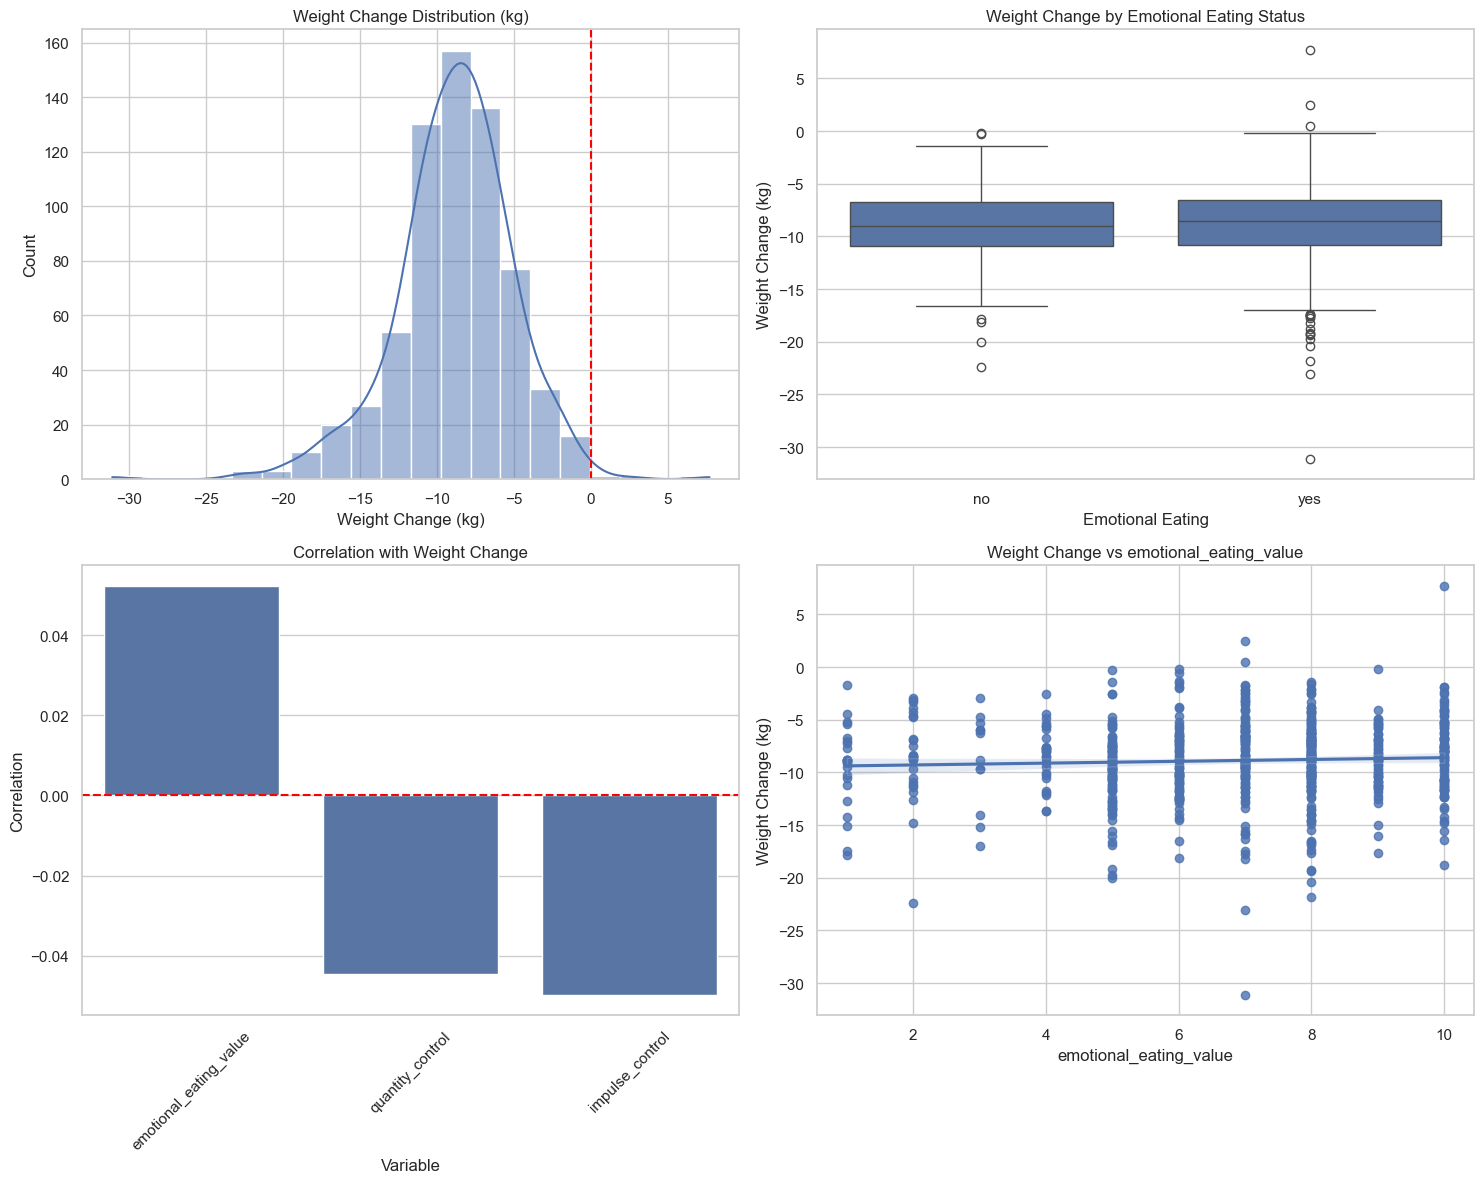

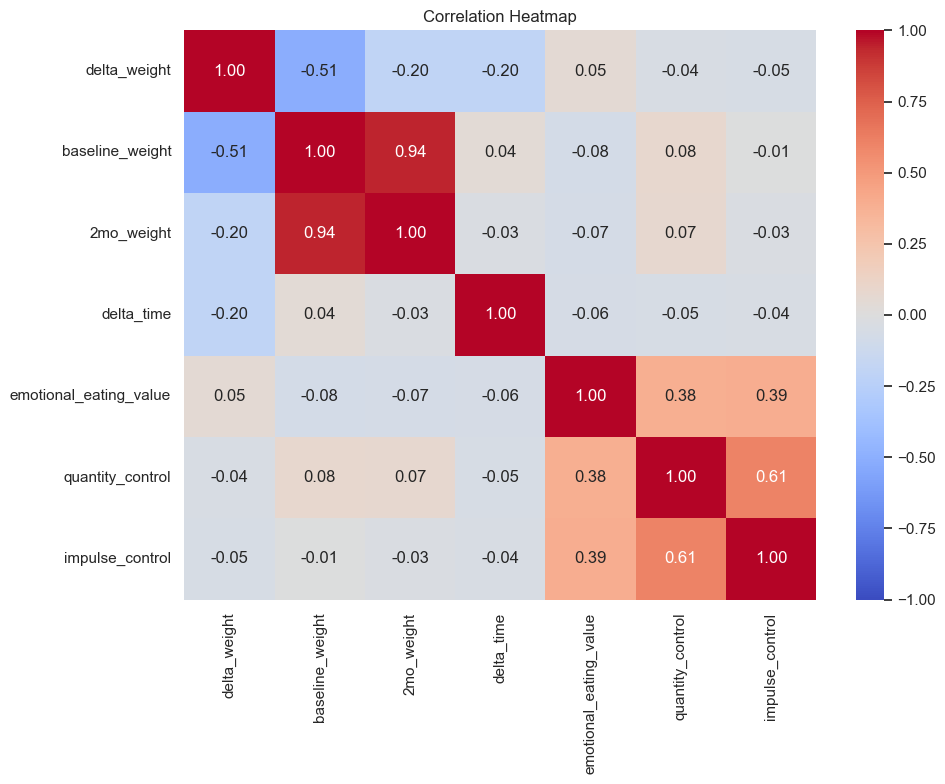


Summary Statistics for Delta Weight by Emotional Eating:
                  count      mean       std   min     25%  50%    75%  max
emotional_eating                                                          
no                138.0 -9.124638  3.697401 -22.4 -10.900 -9.0 -6.725 -0.2
yes               532.0 -8.809774  3.874201 -31.1 -10.825 -8.5 -6.500  7.7

Correlation with Weight Change:
                 Variable  Correlation   p-value
0  emotional_eating_value     0.052333  0.176051
1        quantity_control    -0.044518  0.249838
2         impulse_control    -0.049772  0.198200


In [7]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Connect to the database to get emotional eating variables
conn = sqlite3.connect("emotional_all_notna.sqlite")

# Load emotional variables from medical_records table
query = """
SELECT medical_record_id, patient_id, hunger, satiety, emotional_eating,
       emotional_eating_value, quantity_control, impulse_control
FROM medical_records_colclean
"""
emotional_vars = pd.read_sql_query(query, conn)

# Merge with weight change data
analysis_df = pd.merge(
    emotional_2mo_deltas_singlerec,
    emotional_vars,
    on=['patient_id', 'medical_record_id'],
    how='inner'
)

# Examine variable types before proceeding
print("Variable types:")
for var in ['hunger', 'satiety', 'emotional_eating', 'emotional_eating_value', 'quantity_control', 'impulse_control']:
    print(f"{var}: {analysis_df[var].dtype}, unique values: {analysis_df[var].unique()[:5]}")

# Set up the visualization style
sns.set(style="whitegrid")
plt.figure(figsize=(15, 12))

# 1. Weight change distribution
plt.subplot(2, 2, 1)
sns.histplot(analysis_df['delta_weight'], bins=20, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Weight Change Distribution (kg)')
plt.xlabel('Weight Change (kg)')
plt.ylabel('Count')

# 2. Compare weight change by emotional eating status (yes/no)
plt.subplot(2, 2, 2)
sns.boxplot(x='emotional_eating', y='delta_weight', data=analysis_df)
plt.title('Weight Change by Emotional Eating Status')
plt.xlabel('Emotional Eating')
plt.ylabel('Weight Change (kg)')

# 3. Correlation between quantitative variables and weight change
# Modified: Only use variables that can be converted to float
continuous_vars = ['hunger', 'satiety', 'emotional_eating_value', 'quantity_control', 'impulse_control']
correlations = []

for var in continuous_vars:
    if var in analysis_df.columns:
        # Check if variable can be converted to float
        try:
            # Check if variable contains any non-numeric values
            if pd.to_numeric(analysis_df[var], errors='coerce').isna().any():
                print(f"Skipping {var} - contains non-numeric values")
                continue
                
            corr, p_value = stats.pearsonr(
                pd.to_numeric(analysis_df[var]), 
                analysis_df['delta_weight']
            )
            correlations.append({
                'Variable': var,
                'Correlation': corr,
                'p-value': p_value
            })
        except Exception as e:
            print(f"Error processing {var}: {e}")

corr_df = pd.DataFrame(correlations)

if not corr_df.empty:
    plt.subplot(2, 2, 3)
    sns.barplot(x='Variable', y='Correlation', data=corr_df)
    plt.title('Correlation with Weight Change')
    plt.xticks(rotation=45)
    plt.axhline(y=0, color='red', linestyle='--')

    # 4. Scatterplot matrix for key relationships
    plt.subplot(2, 2, 4)
    # Choose most important variable based on correlation
    if len(correlations) > 0:
        best_predictor = corr_df.loc[corr_df['Correlation'].abs().idxmax(), 'Variable']
        sns.regplot(x=pd.to_numeric(analysis_df[best_predictor]), y='delta_weight', data=analysis_df)
        plt.title(f'Weight Change vs {best_predictor}')
        plt.xlabel(best_predictor)
        plt.ylabel('Weight Change (kg)')

plt.tight_layout()
plt.show()

# For heatmap, only include numeric variables
numeric_vars = []
for var in ['delta_weight', 'baseline_weight', '2mo_weight', 'delta_time'] + continuous_vars:
    if var in analysis_df.columns:
        try:
            if not pd.to_numeric(analysis_df[var], errors='coerce').isna().any():
                numeric_vars.append(var)
        except:
            pass

if len(numeric_vars) > 1:
    plt.figure(figsize=(10, 8))
    correlation_matrix = analysis_df[numeric_vars].apply(pd.to_numeric).corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    plt.title('Correlation Heatmap')
    plt.tight_layout()
    plt.show()

# Display summary statistics
print("\nSummary Statistics for Delta Weight by Emotional Eating:")
print(analysis_df.groupby('emotional_eating')['delta_weight'].describe())

print("\nCorrelation with Weight Change:")
if not corr_df.empty:
    print(corr_df)
else:
    print("No valid correlations found")

conn.close()

univariate linear regression models: delta weight and emotional eating variables in the single-record data subset


Summary Statistics:
                       baseline_date  baseline_weight  \
count                            706       706.000000   
mean   2022-12-03 15:07:58.665722368        86.405807   
min              2022-02-07 09:29:38        57.600000   
25%    2022-05-31 10:09:10.249999872        78.800000   
50%              2022-11-15 08:21:31        85.400000   
75%    2023-04-26 02:45:55.750000128        91.200000   
max              2024-01-16 07:18:51       125.900000   
std                              NaN        11.282609   

                       followup_date  followup_weight  delta_days  \
count                            706       706.000000  706.000000   
mean   2023-01-18 01:12:00.433427712        78.886827   44.889518   
min              2022-03-21 14:01:37        57.900000   40.000000   
25%              2022-07-15 07:43:04        71.525000   41.000000   
50%       2023-01-10 09:47:10.500000        78.100000   42.000000   
75%       2023-06-11 18:33:36.500000        84.0000

c:\Users\Felhasználó\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\_lib\deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


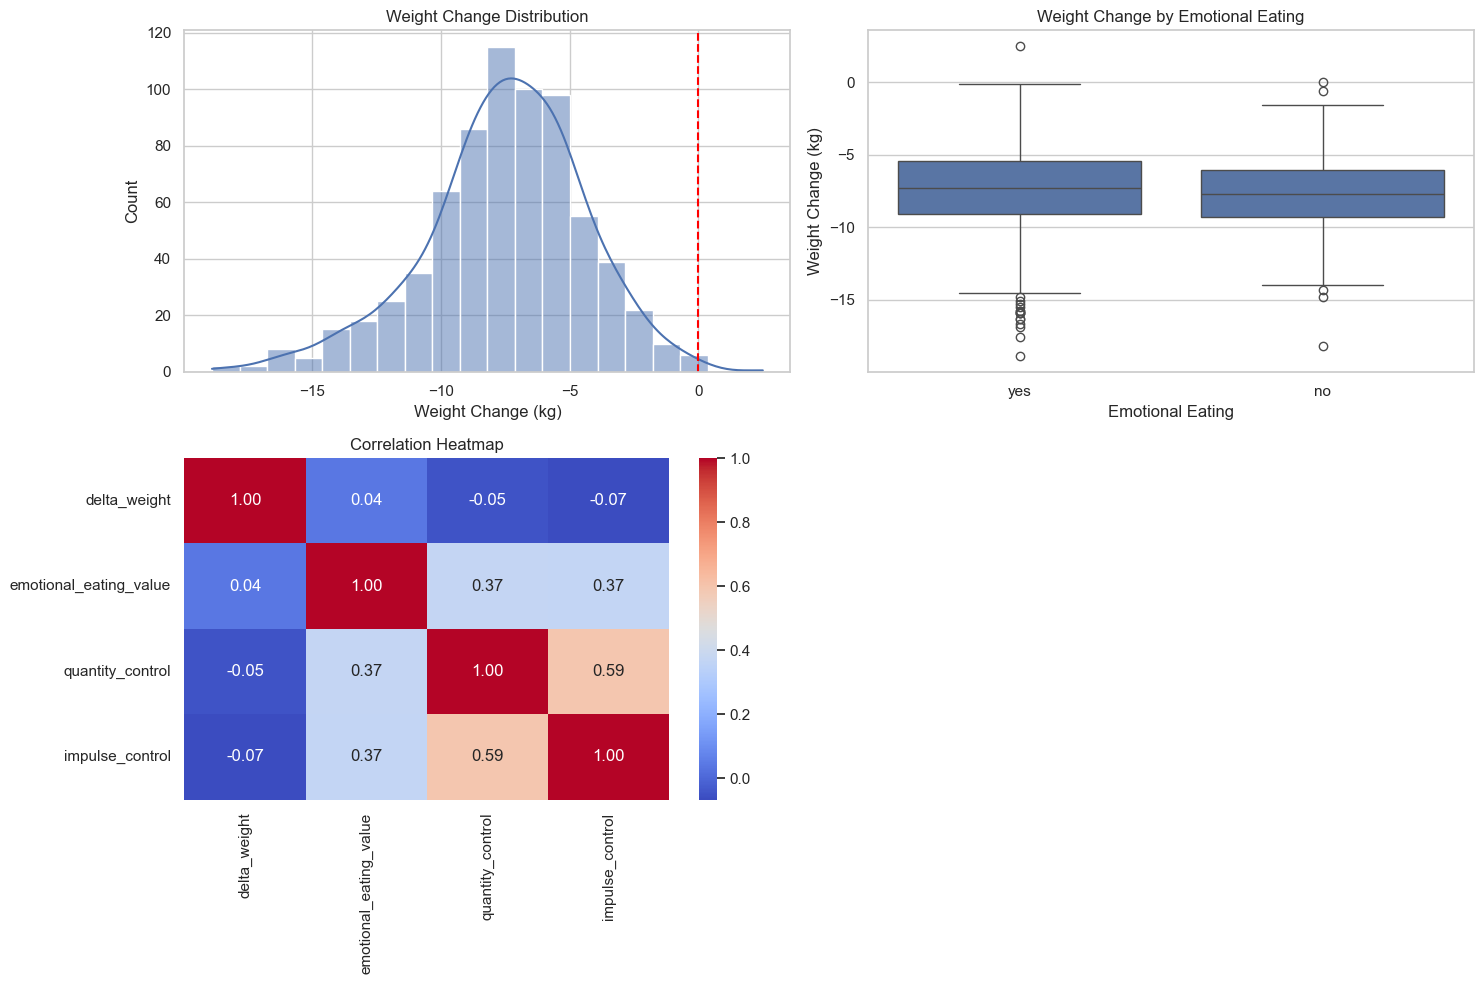

In [10]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, pearsonr
import statsmodels.api as sm
from datetime import timedelta
import re

# Database connection
def connect_to_database(db_path):
    """Connect to the SQLite database."""
    return sqlite3.connect(db_path)

# Extract data
def extract_data(conn, query):
    """Run a SQL query and return the result as a pandas DataFrame."""
    return pd.read_sql_query(query, conn)

# Extract eating behavior data
def get_eating_behavior_data(conn):
    """Retrieve patients with complete eating behavior data."""
    query = """
    SELECT DISTINCT medical_record_id, patient_id, emotional_eating, satiety, hunger,
           emotional_eating_value, quantity_control, impulse_control
    FROM medical_records_colclean
    WHERE emotional_eating IS NOT NULL
      AND satiety IS NOT NULL
      AND hunger IS NOT NULL
      AND emotional_eating_value IS NOT NULL
      AND quantity_control IS NOT NULL
      AND impulse_control IS NOT NULL
    """
    return extract_data(conn, query)

# Extract measurements data
def get_measurements_data(conn, patient_ids):
    """Retrieve measurements for patients with eating behavior data."""
    query = f"""
    SELECT *
    FROM measurements_colclean
    WHERE patient_id IN ({','.join([f"'{pid}'" for pid in patient_ids])})
    ORDER BY patient_id, measurement_date
    """
    return extract_data(conn, query)

# Merge measurements with prescriptions
def link_measurements_to_prescriptions(measurements, prescriptions):
    """Link measurements to prescriptions based on patient_id and date ranges."""
    prescriptions['prescription_creation_date'] = pd.to_datetime(prescriptions['prescription_creation_date'])
    prescriptions['prescription_validity_end_date'] = pd.to_datetime(prescriptions['prescription_validity_end_date'])
    measurements['measurement_date'] = pd.to_datetime(measurements['measurement_date'])

    merged = pd.merge(measurements, prescriptions, on="patient_id", how="left")
    linked = merged[
        (merged['measurement_date'] >= merged['prescription_creation_date']) &
        (merged['measurement_date'] <= merged['prescription_validity_end_date'])
    ]
    return linked

# Calculate deltas
def calculate_deltas(linked):
    """Calculate baseline and follow-up measurements for each patient."""
    baseline_2mo_pairs = []
    for (patient_id, medical_record_id), group in linked.groupby(['patient_id', 'medical_record_id']):
        if len(group) < 2:
            continue
        group_sorted = group.sort_values('measurement_date')
        baseline = group_sorted.iloc[0]
        baseline_date = baseline['measurement_date']
        target_date = baseline_date + timedelta(days=60)
        valid_followups = group_sorted[
            (group_sorted['measurement_date'] > baseline_date + timedelta(days=40)) &
            (group_sorted['measurement_date'] < baseline_date + timedelta(days=80))
        ]
        if len(valid_followups) == 0:
            continue
        followup = valid_followups.iloc[0]
        record = {
            'patient_id': patient_id,
            'medical_record_id': medical_record_id,
            'baseline_date': baseline_date,
            'baseline_weight': baseline['weight_kg'],
            'followup_date': followup['measurement_date'],
            'followup_weight': followup['weight_kg'],
            'delta_days': (followup['measurement_date'] - baseline_date).days,
            'delta_weight': followup['weight_kg'] - baseline['weight_kg']
        }
        baseline_2mo_pairs.append(record)
    return pd.DataFrame(baseline_2mo_pairs)

# Statistical analysis
def perform_statistical_analysis(data):
    """Perform statistical analysis on the dataset."""
    print("\nSummary Statistics:")
    print(data.describe())

    # Correlation analysis
    continuous_vars = ['emotional_eating_value', 'quantity_control', 'impulse_control']
    correlations = []
    for var in continuous_vars:
        if var in data.columns:
            corr, p_val = pearsonr(data[var], data['delta_weight'])
            correlations.append({'Variable': var, 'Correlation': corr, 'p-value': p_val})
    corr_df = pd.DataFrame(correlations)
    print("\nCorrelation Analysis:")
    print(corr_df)

    # T-tests for categorical variables
    categorical_vars = ['emotional_eating', 'hunger', 'satiety']
    for var in categorical_vars:
        if var in data.columns:
            group1 = data[data[var] == 'Sí']['delta_weight']
            group2 = data[data[var] == 'No']['delta_weight']
            t_stat, p_val = ttest_ind(group1, group2, nan_policy='omit')
            print(f"\nT-test for {var}:")
            print(f"T-statistic: {t_stat}, p-value: {p_val}")

# Visualization
def visualize_data(data):
    """Visualize the data."""
    sns.set(style="whitegrid")
    plt.figure(figsize=(15, 10))

    # Weight change distribution
    plt.subplot(2, 2, 1)
    sns.histplot(data['delta_weight'], bins=20, kde=True)
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title('Weight Change Distribution')
    plt.xlabel('Weight Change (kg)')
    plt.ylabel('Count')

    # Boxplot for emotional eating
    plt.subplot(2, 2, 2)
    sns.boxplot(x='emotional_eating', y='delta_weight', data=data)
    plt.title('Weight Change by Emotional Eating')
    plt.xlabel('Emotional Eating')
    plt.ylabel('Weight Change (kg)')

    # Correlation heatmap
    plt.subplot(2, 2, 3)
    corr_matrix = data[['delta_weight', 'emotional_eating_value', 'quantity_control', 'impulse_control']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap')

    plt.tight_layout()
    plt.show()

# Main function
def main():
    db_path = "emotional_all_notna.sqlite"
    conn = connect_to_database(db_path)

    # Step 1: Extract data
    eating_behavior_data = get_eating_behavior_data(conn)
    patient_ids = eating_behavior_data['patient_id'].unique()
    measurements_data = get_measurements_data(conn, patient_ids)
    prescriptions_data = extract_data(conn, "SELECT * FROM prescriptions_colclean")

    # Step 2: Link measurements to prescriptions
    linked_data = link_measurements_to_prescriptions(measurements_data, prescriptions_data)

    # Step 3: Calculate deltas
    deltas = calculate_deltas(linked_data)

    # Step 4: Merge with eating behavior data
    merged_data = pd.merge(deltas, eating_behavior_data, on=['patient_id', 'medical_record_id'], how='inner')

    # Step 5: Perform statistical analysis
    perform_statistical_analysis(merged_data)

    # Step 6: Visualize data
    visualize_data(merged_data)

    conn.close()

if __name__ == "__main__":
    main()

Identify the first and last measurement of each prescription, program step, and medical record. 

In [ ]:
import sqlite3
import pandas as pd
import re

# Connect to the filtered database
conn = sqlite3.connect("emotional_all_notna.sqlite")

# Load the prescriptions and measurements tables
presc = pd.read_sql_query("SELECT * FROM prescriptions_colclean", conn)
meas = pd.read_sql_query("SELECT * FROM measurements_colclean", conn)

# Convert date columns to datetime
presc['prescription_creation_date'] = pd.to_datetime(presc['prescription_creation_date'])
presc['prescription_validity_end_date'] = pd.to_datetime(presc['prescription_validity_end_date'])
meas['measurement_date'] = pd.to_datetime(meas['measurement_date'])

# Function to extract step number from text
def extract_step_number(step_text):
    if pd.isna(step_text):
        return None
    # Try to extract numbers from the text using regex
    match = re.search(r'(?:Paso\s+)?(\d+)', step_text)
    if match:
        return int(match.group(1))
    return None

# Add step_nr column to prescriptions
presc['step_nr'] = presc['step'].apply(extract_step_number)

# Merge the measurements (base) with prescriptions via patient_id
merged = pd.merge(meas, presc, on="patient_id", how="left", suffixes=('_meas', '_presc'))

# Filter the merged table: keep only rows where the measurement date lies within the prescription interval
linked = merged[
    (merged['measurement_date'] >= merged['prescription_creation_date']) &
    (merged['measurement_date'] <= merged['prescription_validity_end_date'])
].copy()

# Select only the specified columns in the requested order
linked = linked[[
    'patient_id', 
    'medical_record_id', 
    'prescription_id',
    'measurement_date', 
    'prescription_creation_date', 
    'prescription_validity_end_date',
    'prescription_validity_days',
    'method', 
    'step',
    'step_nr', 
    'weight_kg'
]]

# Sort the rows by the specified columns
linked = linked.sort_values([
    'patient_id', 
    'medical_record_id', 
    'prescription_id', 
    'measurement_date'
])

# Create a new dataframe with only first and last measurements per prescription
# Group by patient_id, medical_record_id, prescription_id
grouped = linked.groupby(['patient_id', 'medical_record_id', 'prescription_id'])

# Find indices of first and last measurements for each group
first_indices = grouped['measurement_date'].idxmin().tolist()
last_indices = grouped['measurement_date'].idxmax().tolist()

# Combine the indices and drop duplicates (in case there's only one measurement)
selected_indices = list(set(first_indices + last_indices))

# Create the filtered dataframe
linked_firstlast = linked.loc[selected_indices].sort_values([
    'patient_id', 
    'medical_record_id', 
    'prescription_id', 
    'measurement_date'
])

# Create the wide format version (one row per prescription)
# First, create separate dataframes for the first and last measurements
first_measurements = linked.loc[first_indices].copy()
last_measurements = linked.loc[last_indices].copy()

# Rename columns for clarity
first_measurements = first_measurements.rename(columns={
    'measurement_date': 'first_measurement_prescription',
    'weight_kg': 'first_weight_prescription'
})

last_measurements = last_measurements.rename(columns={
    'measurement_date': 'last_measurement_prescription',
    'weight_kg': 'last_weight_prescription'
})

# Merge the first and last measurement dataframes
linked_firstlast_wide = pd.merge(
    first_measurements[['patient_id', 'medical_record_id', 'prescription_id', 
                       'prescription_creation_date', 'prescription_validity_end_date',
                       'prescription_validity_days', 'method', 'step', 'step_nr',
                       'first_measurement_prescription', 'first_weight_prescription']],
    last_measurements[['patient_id', 'medical_record_id', 'prescription_id',
                      'last_measurement_prescription', 'last_weight_prescription']],
    on=['patient_id', 'medical_record_id', 'prescription_id']
)

# Calculate additional metrics for prescriptions
linked_firstlast_wide['days_between_measurements_prescription'] = (
    linked_firstlast_wide['last_measurement_prescription'] - 
    linked_firstlast_wide['first_measurement_prescription']
).dt.days

linked_firstlast_wide['delta_weight_prescription'] = (
    linked_firstlast_wide['last_weight_prescription'] - 
    linked_firstlast_wide['first_weight_prescription']
)

# Sort by patient_id > medical_record_id > prescription_creation_date
linked_firstlast_wide = linked_firstlast_wide.sort_values([
    'patient_id', 
    'medical_record_id', 
    'prescription_creation_date'
])

# Step-level aggregations
# Group by patient_id, medical_record_id, and step_nr
step_grouped = linked.groupby(['patient_id', 'medical_record_id', 'step_nr'])

# Get the first and last measurements for each step within each medical record
step_first_indices = step_grouped['measurement_date'].idxmin().tolist()
step_last_indices = step_grouped['measurement_date'].idxmax().tolist()

# Create dataframes for first and last measurements per step
step_first = linked.loc[step_first_indices].copy()
step_last = linked.loc[step_last_indices].copy()

# Rename columns for clarity
step_first = step_first.rename(columns={
    'measurement_date': 'first_measurement_step',
    'weight_kg': 'first_weight_step'
})

step_last = step_last.rename(columns={
    'measurement_date': 'last_measurement_step',
    'weight_kg': 'last_weight_step'
})

# Create a step-level summary dataframe
step_summary = pd.merge(
    step_first[['patient_id', 'medical_record_id', 'step_nr', 
                'first_measurement_step', 'first_weight_step']],
    step_last[['patient_id', 'medical_record_id', 'step_nr',
               'last_measurement_step', 'last_weight_step']],
    on=['patient_id', 'medical_record_id', 'step_nr']
)

# Calculate step-level metrics
step_summary['days_between_measurements_step'] = (
    step_summary['last_measurement_step'] - 
    step_summary['first_measurement_step']
).dt.days

step_summary['delta_weight_step'] = (
    step_summary['last_weight_step'] - 
    step_summary['first_weight_step']
)

# Merge the step-level summaries back to the prescription-level dataframe
linked_firstlast_wide = pd.merge(
    linked_firstlast_wide,
    step_summary,
    on=['patient_id', 'medical_record_id', 'step_nr'],
    how='left'
)

# NEW: Medical record-level aggregations
# Group by patient_id and medical_record_id
medrec_grouped = linked.groupby(['patient_id', 'medical_record_id'])

# Get the first and last measurements for each medical record
medrec_first_indices = medrec_grouped['measurement_date'].idxmin().tolist()
medrec_last_indices = medrec_grouped['measurement_date'].idxmax().tolist()

# Create dataframes for first and last measurements per medical record
medrec_first = linked.loc[medrec_first_indices].copy()
medrec_last = linked.loc[medrec_last_indices].copy()

# Rename columns for clarity
medrec_first = medrec_first.rename(columns={
    'measurement_date': 'first_measurement_medrec',
    'weight_kg': 'first_weight_medrec'
})

medrec_last = medrec_last.rename(columns={
    'measurement_date': 'last_measurement_medrec',
    'weight_kg': 'last_weight_medrec'
})

# Create a medical record-level summary dataframe
medrec_summary = pd.merge(
    medrec_first[['patient_id', 'medical_record_id', 
                 'first_measurement_medrec', 'first_weight_medrec']],
    medrec_last[['patient_id', 'medical_record_id',
                'last_measurement_medrec', 'last_weight_medrec']],
    on=['patient_id', 'medical_record_id']
)

# Calculate medical record-level metrics
medrec_summary['days_between_measurements_medrec'] = (
    medrec_summary['last_measurement_medrec'] - 
    medrec_summary['first_measurement_medrec']
).dt.days

medrec_summary['delta_weight_medrec'] = (
    medrec_summary['last_weight_medrec'] - 
    medrec_summary['first_weight_medrec']
)

# Merge the medical record-level summaries back to the result dataframe
linked_firstlast_wide = pd.merge(
    linked_firstlast_wide,
    medrec_summary,
    on=['patient_id', 'medical_record_id'],
    how='left'
)

# Reorder columns 
linked_firstlast_wide = linked_firstlast_wide[['patient_id', 'medical_record_id', 'prescription_id',
       'prescription_creation_date', 'prescription_validity_end_date',
       'prescription_validity_days', 'method', 'step', 'step_nr',
       'first_measurement_prescription', 'last_measurement_prescription', 
       'days_between_measurements_prescription',
       'first_weight_prescription', 'last_weight_prescription', 'delta_weight_prescription',
       'first_measurement_step', 'last_measurement_step', 'days_between_measurements_step',
       'first_weight_step', 'last_weight_step', 'delta_weight_step', 
       'first_measurement_medrec',  'last_measurement_medrec', 'days_between_measurements_medrec',
       'first_weight_medrec', 'last_weight_medrec', 'delta_weight_medrec']


# Display the first few rows of the final dataframe
print("Final dataframe with prescription, step, and medical record-level summaries:")
print(linked_firstlast_wide.head())

# Show some statistics about the unique values
print("\nNumber of unique patients:", linked_firstlast_wide['patient_id'].nunique())
print("Number of unique medical records:", linked_firstlast_wide['medical_record_id'].nunique())
print("Number of unique prescriptions:", linked_firstlast_wide['prescription_id'].nunique())
print("Average weight change per medical record:", linked_firstlast_wide['delta_weight_medrec'].mean())

conn.close()

Final dataframe with prescription, step, and medical record-level summaries:
      patient_id medical_record_id prescription_id prescription_creation_date  \
0  9896E54CEB969     12BEA142A682D   150EF94D15241        2022-05-06 19:06:00   
1  9896F54CEB969     1357AA42A682D   1652024D15241        2023-01-12 20:04:22   
2  9896F54CEB969     1357AA42A682D   165FF44D15241        2023-01-25 20:38:29   
3  9897484CEB969     12B86242A682D   14F8194D15241        2022-04-20 18:40:00   
4  9897484CEB969     12B86242A682D   15064E4D15241        2022-05-02 18:21:51   

  prescription_validity_end_date  prescription_validity_days method  \
0            2022-05-21 19:06:00                          15    PNK   
1            2023-01-27 20:04:22                          15    PNK   
2            2023-02-09 20:38:29                          15    PNK   
3            2022-05-05 18:40:00                          15    PNK   
4            2022-05-17 18:21:51                          15    PNK   

         

### -old- Eating behavior with genetics-related queries

Query the available SNPs, and the number of patients they are collected from. 

In [ ]:
import sqlite3

# Connect to the SQLite database file
conn = sqlite3.connect('pnk_db2_colclean.sqlite')
cursor = conn.cursor()

# Count total number of distinct patients
cursor.execute("SELECT COUNT(DISTINCT patient_id) FROM alleles_standard_clean")
total_patients = cursor.fetchone()[0]

# Query to find SNPs present in all patients
query = """
SELECT rs, COUNT(DISTINCT patient_id) as patient_count
FROM alleles_standard_clean
WHERE value IS NOT NULL
GROUP BY rs
HAVING COUNT(DISTINCT patient_id) = ?
ORDER BY rs;
"""

cursor.execute(query, (total_patients,))
results = cursor.fetchall()

print(f"Total number of patients: {total_patients}")
print("\nSNPs present in all patients:")
if len(results) == 0:
    print("No SNPs found in all patients")
else:
    for row in results:
        print(f"SNP: {row[0]} (present in {row[1]} patients)")

# Let's also check the distribution of SNPs
verification_query = """
SELECT rs, COUNT(DISTINCT patient_id) as patient_count
FROM alleles_standard_clean
WHERE value IS NOT NULL
GROUP BY rs
ORDER BY patient_count DESC
LIMIT 38;
"""

print("\nMost common SNPs:")
cursor.execute(verification_query)
results = cursor.fetchall()

# Print results as a numbered list with coverage percentage
for i, row in enumerate(results, 1):
    coverage_percentage = (row[1] / total_patients) * 100
    print(f"{i}. SNP: {row[0]} (present in {row[1]} patients, {coverage_percentage:.1f}% coverage)")

conn.close()

Total number of patients: 2472

SNPs present in all patients:
No SNPs found in all patients

Most common SNPs:
1. SNP: rs894160 (present in 2469 patients, 99.9% coverage)
2. SNP: rs7498665 (present in 2469 patients, 99.9% coverage)
3. SNP: rs696217 (present in 2469 patients, 99.9% coverage)
4. SNP: rs6265 (present in 2469 patients, 99.9% coverage)
5. SNP: rs601338 (present in 2469 patients, 99.9% coverage)
6. SNP: rs5082 (present in 2469 patients, 99.9% coverage)
7. SNP: rs4994 (present in 2469 patients, 99.9% coverage)
8. SNP: rs361525 (present in 2469 patients, 99.9% coverage)
9. SNP: rs1801282 (present in 2469 patients, 99.9% coverage)
10. SNP: rs1801260 (present in 2469 patients, 99.9% coverage)
11. SNP: rs1800896 (present in 2469 patients, 99.9% coverage)
12. SNP: rs1800795 (present in 2469 patients, 99.9% coverage)
13. SNP: rs1800206 (present in 2469 patients, 99.9% coverage)
14. SNP: rs1799883 (present in 2469 patients, 99.9% coverage)
15. SNP: rs17782313 (present in 2469 patien

Identify the subset of patients with available data on eating behavior in the medical_records_standard_clean registry - 1499 patients if excluding duplicates (some patients, in the number of the thousands, have at least two medical records. This might be due to diet restart, and it needs to be verified).

In [ ]:
import sqlite3
import pandas as pd

# Connect to the database
conn = sqlite3.connect('pnk_db2_colclean.sqlite')

# Define the columns we want to check for non-NA values
eating_behavior_cols = [
    'emotional_eating',
    'satiety',
    'hunger',
    'emotional_eating_value',
    'quantity_control',
    'impulse_control'
]

# Modified query to select patient_id first
query = f"""
WITH unique_patient_records AS (
    SELECT DISTINCT medical_record_id, patient_id
    FROM prescriptions_standard_clean
)
SELECT p.patient_id, m.*
FROM medical_records_standard_clean m
JOIN unique_patient_records p ON m.medical_record_id = p.medical_record_id
WHERE {' AND '.join([f'm.{col} IS NOT NULL' for col in eating_behavior_cols])}
"""

# Load the data into a pandas DataFrame
eating_behavior_df = pd.read_sql_query(query, conn)

# Remove rows where patient_id appears more than once
eating_behavior_df = eating_behavior_df[~eating_behavior_df['patient_id'].duplicated(keep=False)]

# Sort by patient_id
eating_behavior_df = eating_behavior_df.sort_values('patient_id', ascending=True)

# Print some basic information about the subset
print(f"Total number of records: {len(eating_behavior_df)}")
print(f"Number of unique patients: {eating_behavior_df['patient_id'].nunique()}")
print(f"Number of unique medical records: {eating_behavior_df['medical_record_id'].nunique()}")

print("\nVerification of no duplicates:")
print(f"Maximum occurrences of any patient_id: {eating_behavior_df['patient_id'].value_counts().max()}")

print("\nNumber of non-null values in key columns:")
print(eating_behavior_df[['patient_id', 'medical_record_id'] + eating_behavior_cols].info())

# Close the connection
conn.close()

# Display the DataFrame
eating_behavior_df

# Optional: Save the DataFrame for later use
eating_behavior_df.to_csv('eating_behavior.csv', index=False)

Total number of records: 1499
Number of unique patients: 1499
Number of unique medical records: 1499

Verification of no duplicates:
Maximum occurrences of any patient_id: 1

Number of non-null values in key columns:
<class 'pandas.core.frame.DataFrame'>
Index: 1499 entries, 384 to 1546
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   patient_id              1499 non-null   object 
 1   medical_record_id       1499 non-null   object 
 2   emotional_eating        1499 non-null   object 
 3   satiety                 1499 non-null   object 
 4   hunger                  1499 non-null   object 
 5   emotional_eating_value  1499 non-null   float64
 6   quantity_control        1499 non-null   float64
 7   impulse_control         1499 non-null   float64
dtypes: float64(3), object(5)
memory usage: 105.4+ KB
None


In [ ]:
eating_behavior_df

Identify patients with eating behavior AND genetics data available - 160 patients

In [ ]:
import sqlite3
import pandas as pd

# Connect to the database
conn = sqlite3.connect('pnk_db2_colclean.sqlite')

# Define the columns we want to check for non-NA values
eating_behavior_cols = [
    'emotional_eating',
    'satiety',
    'hunger',
    'emotional_eating_value',
    'quantity_control',
    'impulse_control'
]

# Create the complex SQL query
query = """
WITH 
-- First, get patients with complete eating behavior data
eating_behavior_records AS (
    SELECT medical_record_id
    FROM medical_records_standard_clean
    WHERE emotional_eating IS NOT NULL
    AND satiety IS NOT NULL
    AND hunger IS NOT NULL
    AND emotional_eating_value IS NOT NULL
    AND quantity_control IS NOT NULL
    AND impulse_control IS NOT NULL
),
-- Then, get patients with exactly one medical record
single_record_patients AS (
    SELECT patient_id, medical_record_id
    FROM prescriptions_standard_clean
    GROUP BY patient_id
    HAVING COUNT(DISTINCT medical_record_id) = 1
),
-- Get patients with genomics data
genomics_patients AS (
    SELECT patient_id, genomics_sample_id
    FROM patients_standard_clean
    WHERE genomics_available = 'Sí'
)
-- Combine all conditions
SELECT DISTINCT
    s.medical_record_id,
    s.patient_id,
    g.genomics_sample_id,
    m.*
FROM single_record_patients s
JOIN eating_behavior_records e ON s.medical_record_id = e.medical_record_id
JOIN genomics_patients g ON s.patient_id = g.patient_id
JOIN medical_records_standard_clean m ON s.medical_record_id = m.medical_record_id
"""

# Load the data into a pandas DataFrame
eating_behavior_with_genetics_df = pd.read_sql_query(query, conn)

# Print summary statistics
print("Summary of the final dataset:")
print(f"Total number of records: {len(eating_behavior_with_genetics_df)}")
print(f"Number of unique patients: {eating_behavior_with_genetics_df['patient_id'].nunique()}")
print(f"Number of unique medical records: {eating_behavior_with_genetics_df['medical_record_id'].nunique()}")
print(f"Number of unique genomics samples: {eating_behavior_with_genetics_df['genomics_sample_id'].nunique()}")

# Verify data completeness
print("\nVerifying data completeness:")
print(eating_behavior_with_genetics_df[['patient_id', 'medical_record_id', 'genomics_sample_id'] + eating_behavior_cols].info())

# Close the connection
conn.close()

# Display the first few rows of the DataFrame
eating_behavior_with_genetics_df

# Optional: Save the DataFrame
eating_behavior_with_genetics_df.to_csv('eating_behavior_genetics.csv', index=False)

Summary of the final dataset:
Total number of records: 160
Number of unique patients: 160
Number of unique medical records: medical_record_id    160
medical_record_id    160
dtype: int64
Number of unique genomics samples: 160

Verifying data completeness:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   patient_id              160 non-null    object 
 1   medical_record_id       160 non-null    object 
 2   medical_record_id       160 non-null    object 
 3   genomics_sample_id      160 non-null    object 
 4   emotional_eating        160 non-null    object 
 5   satiety                 160 non-null    object 
 6   hunger                  160 non-null    object 
 7   emotional_eating_value  160 non-null    float64
 8   quantity_control        160 non-null    float64
 9   impulse_control         160 non-null    float64
dty

In [ ]:
eating_behavior_with_genetics_df

Retrieve the weight and body composition measurements of patients with available eating behavior data

In [ ]:
import sqlite3
import pandas as pd

# Get list of patient IDs from eating_behavior_df
eating_behavior_patient_ids = eating_behavior_df['patient_id'].tolist()

# Connect to the database
conn = sqlite3.connect('pnk_db2_colclean.sqlite')

# First, let's check the table structure
cursor = conn.cursor()
cursor.execute("PRAGMA table_info(measurements_standard_clean)")
columns = cursor.fetchall()
print("Table columns:")
for col in columns:
    print(col[1])  # Print column names

# Create query using the list of patient IDs and correct date column name
query = f"""
SELECT *
FROM measurements_standard_clean
WHERE patient_id IN ('{"','".join(eating_behavior_patient_ids)}')
ORDER BY patient_id, measurement_date
"""

# Load data into DataFrame
eating_behavior_measurements = pd.read_sql_query(query, conn)

# Print summary statistics
print("\nSummary of measurements data:")
print("-" * 50)
print(f"Total number of measurements: {len(eating_behavior_measurements)}")
print(f"Number of unique patients: {eating_behavior_measurements['patient_id'].nunique()}")
print(f"\nColumns in the dataset:")
print(eating_behavior_measurements.info())

# Close connection
conn.close()

# Display the table
eating_behavior_measurements

# Sort the DataFrame by patient_id and measurement_date (if not already sorted)
eating_behavior_measurements = eating_behavior_measurements.sort_values(['patient_id', 'measurement_date'])

# Create an empty row with NaN values and the same columns as the DataFrame
empty_row = pd.DataFrame({col: [None] for col in eating_behavior_measurements.columns})

# Insert an empty row after each group of patient_id
eating_behavior_measurements_with_separator_rows = (
    eating_behavior_measurements.groupby('patient_id', group_keys=True)
    .apply(lambda group: pd.concat([group, empty_row], ignore_index=True))
    .reset_index(drop=True)
)

# Display the modified DataFrame
eating_behavior_measurements_with_separator_rows

Table columns:
patient_id
measurement_date
weight_kg
bmi
bmr_kcal
fat_%
vat_%
muscle_%
water_%

Summary of measurements data:
--------------------------------------------------
Total number of measurements: 25669
Number of unique patients: 1499

Columns in the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25669 entries, 0 to 25668
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   patient_id        25669 non-null  object 
 1   measurement_date  25669 non-null  object 
 2   weight_kg         25669 non-null  float64
 3   bmi               25669 non-null  float64
 4   bmr_kcal          25196 non-null  float64
 5   fat_%             25570 non-null  float64
 6   vat_%             16616 non-null  float64
 7   muscle_%          25669 non-null  float64
 8   water_%           25669 non-null  float64
dtypes: float64(7), object(2)
memory usage: 1.8+ MB
None


C:\Users\Felhasználó\AppData\Local\Temp\ipykernel_22680\1978663348.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  .apply(lambda group: pd.concat([group, empty_row], ignore_index=True))
C:\Users\Felhasználó\AppData\Local\Temp\ipykernel_22680\1978663348.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.concat([group, empty_row], ignore_index=True))


,patient_id,measurement_date,weight_kg,bmi,bmr_kcal,fat_%,vat_%,muscle_%,water_%
0,9896E54CEB969,2022-05-11 11:03:19,96.70,29.85,2021.15,32.37,11.39,34.99,47.63
1,9896E54CEB969,2022-05-12 08:36:04,95.10,29.35,1984.98,32.25,11.10,34.82,47.75
2,9896E54CEB969,2022-05-13 07:57:10,94.40,29.14,1991.37,30.95,10.98,35.88,49.05
3,9896E54CEB969,2022-05-14 07:54:44,93.80,28.95,1964.97,31.63,10.87,35.16,48.37
4,9896E54CEB969,2022-05-15 09:07:36,93.60,28.89,1980.48,30.49,10.84,36.16,49.51
...,...,...,...,...,...,...,...,...,...
27163,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27164,9AA7A14CEB969,2024-02-27 08:49:48,32.07,42.90,12.67,1.00,3.88,1978.22,31.76
27165,9AA7A14CEB969,2024-02-28 08:45:58,31.87,44.35,12.56,1.00,3.94,1989.60,32.97
27166,9AA7A14CEB969,2024-02-29 08:30:53,31.41,45.22,12.30,1.00,3.97,1971.66,33.52


Retrieve the first and last body composition measurement of each patient, and calculate the number of days passed between the two. 

NEEDS REVISION: Currently, this code does not make too much sense, as it does not account for restarters, it does not include the medical record IDs. 

In [10]:
import pandas as pd

# Ensure the measurements are sorted by patient_id and measurement_date.
df = eating_behavior_measurements.sort_values(['patient_id', 'measurement_date'])

# Extract the first and last measurements for each patient.
first_measurements = df.groupby('patient_id', as_index=False).first()
last_measurements = df.groupby('patient_id', as_index=False).last()

# Calculate follow-up length (days) between the first and last measurements.
# For first measurements, followup_length will be 0.
first_measurements['followup_length'] = 0
last_measurements['followup_length'] = (
    pd.to_datetime(last_measurements['measurement_date']) - pd.to_datetime(first_measurements['measurement_date'])
).dt.days

# Combine the first and last measurements into one DataFrame.
eating_behavior_measurements_delta = pd.concat([first_measurements, last_measurements], ignore_index=True)

# Sort again by patient_id and measurement_date to have the first measurement (with 0 days) come before the last.
eating_behavior_measurements_delta = eating_behavior_measurements_delta.sort_values(['patient_id', 'measurement_date'])

# Reorder columns so that 'followup_length' is the third column.
columns = eating_behavior_measurements_delta.columns.tolist()
# Assuming the first two columns are 'patient_id' and 'measurement_date'
new_order = [columns[0], columns[1], 'followup_length'] + [col for col in columns if col not in [columns[0], columns[1], 'followup_length']]
eating_behavior_measurements_delta = eating_behavior_measurements_delta[new_order]

# Display summary
print("\nSummary of first/last measurements data:")
print("-" * 50)
print(f"Total number of rows: {len(eating_behavior_measurements_delta)}")
print(f"Number of unique patients: {eating_behavior_measurements_delta['patient_id'].nunique()}")

# Display first few rows
eating_behavior_measurements_delta


Summary of first/last measurements data:
--------------------------------------------------
Total number of rows: 2998
Number of unique patients: 1499


,patient_id,measurement_date,followup_length,weight_kg,bmi,bmr_kcal,fat_%,vat_%,muscle_%,water_%
0,9896E54CEB969,2022-05-11 11:03:19,0,96.70,29.85,2021.15,32.37,11.39,34.99,47.63
1499,9896E54CEB969,2022-05-21 08:47:06,9,28.40,50.19,10.55,2.00,10.66,1954.39,36.50
1,9896F54CEB969,2023-01-17 06:05:55,0,26.40,55.46,9.41,2.00,4.29,1677.59,39.56
1500,9896F54CEB969,2023-10-12 07:15:08,268,25.05,57.58,8.63,1.00,4.50,1622.11,40.81
2,9897484CEB969,2022-04-24 08:02:47,0,63.90,26.60,1332.45,34.76,5.20,34.77,43.43
...,...,...,...,...,...,...,...,...,...,...
2995,9AA6C74CEB969,2024-02-21 10:53:57,0,26.59,41.69,5.20,1.00,4.05,1471.55,31.69
1497,9AA7064CEB969,2024-02-25 09:07:05,0,28.29,40.10,5.53,1.00,4.20,1351.67,32.01
2996,9AA7064CEB969,2024-02-29 08:38:19,3,27.62,41.27,5.40,1.00,4.29,1330.71,32.75
1498,9AA7A14CEB969,2024-02-27 08:49:48,0,32.07,42.90,12.67,1.00,3.88,1978.22,31.76
